## Olivier Couque (246212) - Henry Declety (246433)

# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [2]:
sciper = {'student_1': 246212, 
          'student_2': 246433}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

Using TensorFlow backend.


We modified a little bit the given functions and added some useful ones (to ave and load the histories / models for instance):

In [38]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H1=None, H2=None, H3=None, H4=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H1 is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H1[:xlim[1]-1,k], H1[1:xlim[1],k])] for k in range(H1.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H1 = H1[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H1.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("1st layer of hidden units for GRU")
        plt.show()
        
    if H2 is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H2[:xlim[1]-1,k], H2[1:xlim[1],k])] for k in range(H2.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H2 = H2[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H2.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("2nd layer of hidden units for GRU")
        plt.show()
        
    if H3 is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H3[:xlim[1]-1,k], H3[1:xlim[1],k])] for k in range(H3.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H3 = H3[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H3.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("1st layer of hidden units for RNN")
        plt.show()
        
    if H4 is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H4[:xlim[1]-1,k], H4[1:xlim[1],k])] for k in range(H4.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H4 = H4[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H4.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("2nd layer of hidden units for RNN")
        plt.show()


def plotLearningCurves(History1, History2=None, activation1 = str(), activation2 = str()):
    
    logs = [History1]
    if History2 is not None:
        logs.append(History2)
    
    plt.figure(figsize=(8,4))
    for i, log in enumerate(logs): 
        activation = activation1
        color_p = "red"
        color_t = "orange"
        if i == 1:
            color_p = "blue"
            color_t = "cyan"
            activation = activation2
        plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss ' + activation, color = color_p)
        plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss ' + activation, color = color_p)

        plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss ' + activation, color = color_t)
        plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss' + activation, color = color_t)
    plt.legend(loc='best')
    if len(logs) == 2:
        plt.title("Loss in function of the epoch for the " + activation1 + " and " + activation2 + " models")
    else:
        plt.title("Loss in function of the epoch for the " + activation1 + " model")
        
    plt.figure(figsize=(8,4))
    for i, log in enumerate(logs):
        activation = activation1
        color_p = "red"
        color_t = "orange"
        if i == 1:
            color_p = "blue"
            color_t = "cyan"
            activation = activation2
        plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc ' + activation, color = color_p)
        plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc ' + activation, color = color_p)
    
        plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc ' + activation, color = color_t)
        plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc ' + activation, color = color_t)
    if len(logs) == 2:
        plt.title("Accuracy in function of the epoch for the " + activation1 + " and " + activation2 + " models")
    else:
        plt.title("Accuracy in function of the epoch for the " + activation1 + " model")
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)
  
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4646/45853 melodies retained


### Solution

### Get Pitch at Note On and Duration at Note Off ?

In [4]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        #insert your code here...
        if event.name == "Note On":
            # The strategy is to get the pitch P in the "Note On" and get the duration from the corresponding "Note Off" 
            pitch = event.data[0]
            # Get corresponding "Note Off" to get the duration
            not_found_off = True
            next_i = n + 1
            while not_found_off:
                next_event = events[next_i]
                if next_event.name == "Note Off" and next_event.data[0] == pitch:
                    # Found closing note, append duration to T and pitch to P if duration > 0
                    if next_event.tick > 0:
                        P.append(pitch)
                        T.append(next_event.tick + 1)
                    not_found_off = False
                next_i += 1
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune41674
MIDI events
chorpus/sessiontune41674.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 77 	 Note On 	 105
720 	 77 	 Note Off 	 0
721 	 78 	 Note On 	 80
960 	 78 	 Note Off 	 0
961 	 77 	 Note On 	 95
1200 	 77 	 Note Off 	 0
1201 	 75 	 Note On 	 80
1440 	 75 	 Note Off 	 0
1441 	 73 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
29281 	 75 	 Note On 	 80
29520 	 75 	 Note Off 	 0
29521 	 72 	 Note On 	 80
29760 	 72 	 Note Off 	 0
29761 	 73 	 Note On 	 95
30240 	 73 	 Note Off 	 0
30241 	 68 	 Note On 	 80
30720 	 68 	 Note Off 	 0
########################################

Note representation
{'T': [720, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 480, 720, 240, 240, 240, 240, 240, 480, 480, 720, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 120, 120, 240, 240, 240, 240, 240, 240, 240, 240, 2

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

First we build the dictionaries based on all Pitches and Durations we found in the chorpus

In [6]:
def create_dictionary(dataset):
    """Creates the PT dictionary of unique durations and pitches from the dataset given in parameter."""
    P_dict = {}
    T_dict = {}

    all_possible_P = set()
    all_possible_T = set()

    for label in dataset.keys():
        T = set(dataset[label]['T'])
        P = set(dataset[label]['P'])
        all_possible_P = all_possible_P.union(P)
        all_possible_T = all_possible_T.union(T)

    for i, p in enumerate(sorted(list(all_possible_P))):
        P_dict[p] = i
    for i, t in enumerate(sorted(list(all_possible_T))):
        T_dict[t] = i

    PT_dict = {"P": P_dict, "T": T_dict}
    return PT_dict

Now we translate the pitch duration of each melody to the corresponding integer:

In [7]:
def dataset_int_conversion(dataset, dictionary):
    """Function that creates the dataset converted to integer given the original dataset and the dictionary for conversion."""
    dataset_i = {}

    for label in list(dataset.keys()):
        # Initialize T and P lists 
        dataset_i[label] = {"T": [], "P": []}

        Tseq = dataset[label]['T']
        Pseq = dataset[label]['P']

        Tseq_int = []
        Pseq_int = []

        for t in Tseq:
            Tseq_int.append(dictionary['T'][t])
        for p  in Pseq:
            Pseq_int.append(dictionary['P'][p])

        dataset_i[label]['T'] = Tseq_int
        dataset_i[label]['P'] = Pseq_int
        
    return dataset_i

def to_int(dataset):
    PT_dict = create_dictionary(dataset)
    inverse_dict = {}
    inverse_dict["P"] = {value: key for key, value in PT_dict["P"].items()}
    inverse_dict["T"] = {value: key for key, value in PT_dict["T"].items()}
    return PT_dict, inverse_dict, dataset_int_conversion(dataset, PT_dict)

PT_dict, inverse_dict, dataset_i = to_int(dataset)

We select randomly 2 melodies and represent them in the note and integer translated representations

In [8]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print("Translated integer representation")
    print(dataset_i[label])
    
    # Check if representation is correct:
    for i, p_i in enumerate(dataset_i[label]['P']):
        p = dataset[label]['P'][i]
        if p_i != PT_dict['P'][p]:
            print("Error in P at position {}, found {} and should be {}".format(i, p_i, PT_dict['P'][p]))
            
    for i, t_i in enumerate(dataset_i[label]['T']):
        t = dataset[label]['T'][i]
        if t_i != PT_dict['T'][t]:
            print("Error in T at position {}, found {} and should be {}".format(i, t_i, PT_dict['T'][t]))
    
    print('/n')

sessiontune28306
MIDI events
chorpus/sessiontune28306.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 68 	 Note On 	 105
240 	 68 	 Note Off 	 0
241 	 66 	 Note On 	 80
480 	 66 	 Note Off 	 0
481 	 65 	 Note On 	 105
960 	 65 	 Note Off 	 0
961 	 65 	 Note On 	 80
1200 	 65 	 Note Off 	 0
1201 	 63 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60001 	 61 	 Note On 	 105
60480 	 61 	 Note Off 	 0
60481 	 65 	 Note On 	 80
60960 	 65 	 Note Off 	 0
60961 	 61 	 Note On 	 95
61200 	 61 	 Note Off 	 0
61201 	 65 	 Note On 	 80
61440 	 65 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 480, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 480, 240, 2

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

### Rare Event Suppression:

Counter({240: 614657, 480: 92658, 160: 65990, 120: 48933, 320: 27342, 720: 19516, 60: 14017, 960: 6292, 80: 2844, 360: 1376, 1440: 1127, 470: 517, 230: 495, 1200: 386, 800: 294, 40: 239, 1920: 198, 180: 138, 2400: 115, 150: 106, 950: 94, 710: 90, 350: 87, 310: 72, 30: 60, 1280: 48, 110: 40, 1680: 40, 640: 39, 2880: 37, 2160: 35, 600: 33, 840: 28, 220: 24, 400: 14, 280: 11, 1430: 11, 2640: 10, 90: 8, 940: 6, 3120: 5, 3360: 5, 50: 4, 2040: 4, 560: 4, 420: 4, 45: 4, 1080: 3, 213: 2, 106: 2, 1320: 2, 3840: 2, 300: 2, 231: 2, 200: 2, 460: 2, 700: 2, 780: 1, 3600: 1, 21: 1, 11: 1, 930: 1, 1120: 1})


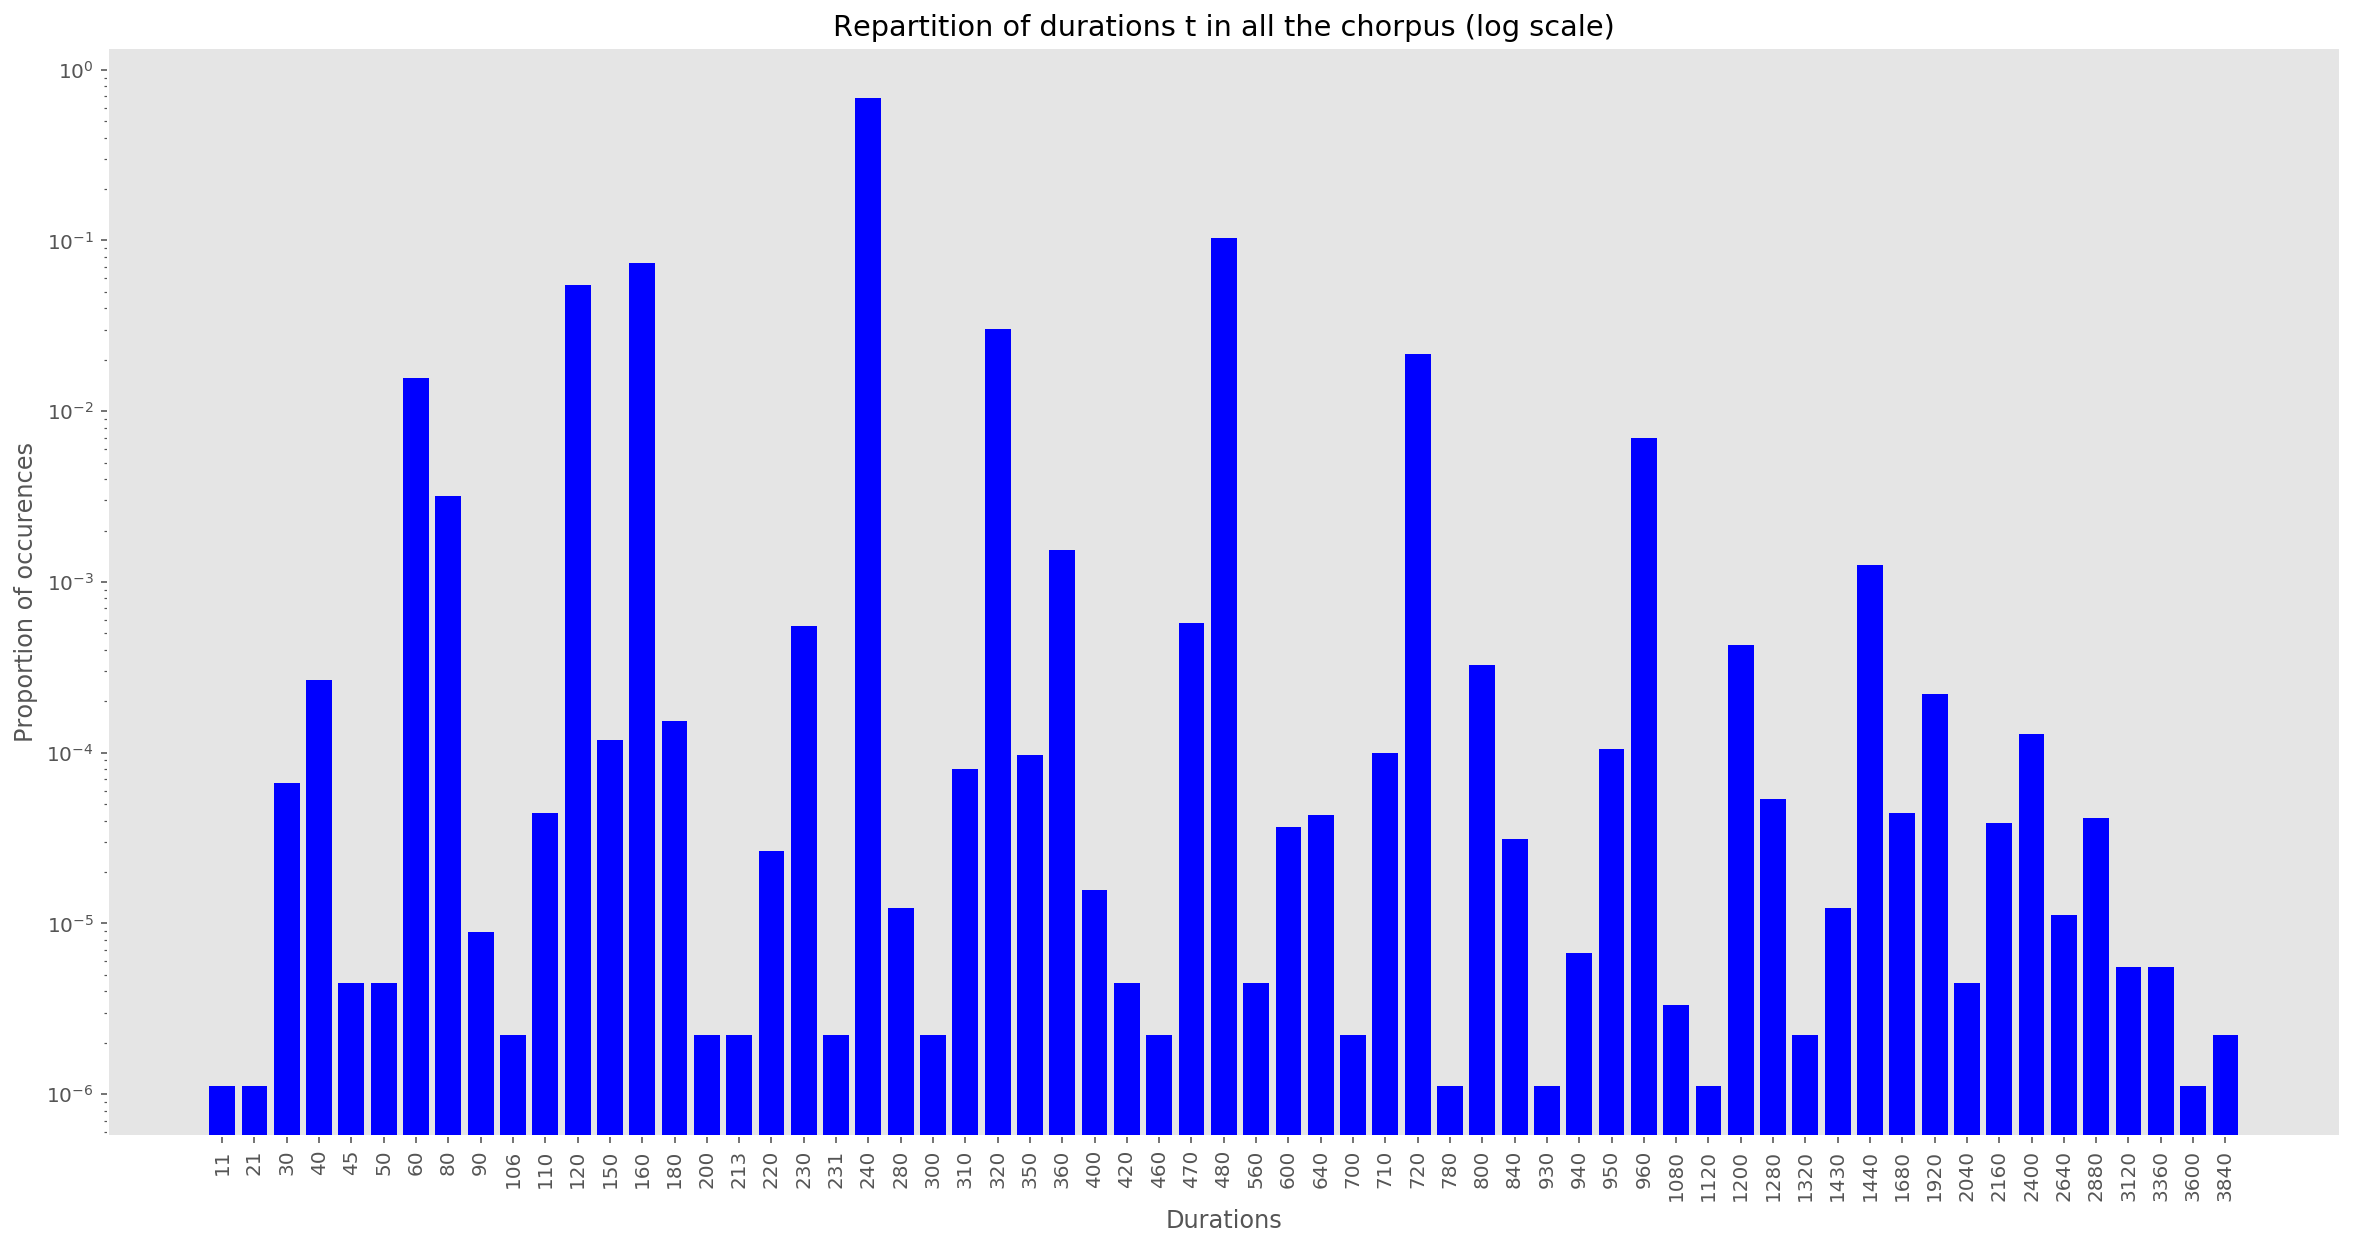

In [9]:
from collections import Counter

def histogram_duration(dataset, type_, title, color = "blue"):
    """type_ is either 'T' for duration or 'P' for pitch"""
    total_counter = Counter()
    for label in list(dataset.keys()):
        T = list(dataset[label][type_])
        total_counter += Counter(T)
    
    print(total_counter)
    durations = sorted(total_counter.keys())
    
    # Compute corresponding list of occurences at each duration
    occurences = []
    for duration in durations:
        occurences.append(total_counter[duration])
    
    # Normalize the occurences
    norm_occurences = np.array(occurences) / sum(occurences)
    
    # Plot the histogram
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.bar(range(1, len(durations) + 1), norm_occurences, align = 'center', color = color)
    plt.title(title)
    if type_ == 'T':
        plt.xlabel("Durations")
    elif type_ == 'P':
        plt.xlabel("Pitches")
    plt.ylabel("Proportion of occurences")
    plt.xticks(range(1, len(durations) + 1), rotation = 90)
    ax.set_xticklabels(durations)
    ax.set_yscale('log')
    plt.show()
    
    norm_counter = {}
    for i, duration in enumerate(durations):
        norm_counter[duration] = norm_occurences[i]
        
    return norm_counter
    
norm_durations = histogram_duration(dataset, 'T', "Repartition of durations t in all the chorpus (log scale)")

The majority of melodies are composed with half notes (240), quarter notes (120) and full notes (480). Careful of log scale on the graph !

We now remove the melodies in the chorpus that contain the rare durations:
We found the min_norm = 0.00022 after some runs in order to have our final ratio (size of cleaned dataset over size of original dataset) the closest to 0.95.

In [10]:
min_norm = 0.00022

durations_to_remove = []
for duration, norm in norm_durations.items():
    if norm < min_norm:
        durations_to_remove.append(duration)
        
print("Durations to remove: {}".format(durations_to_remove))

# Remove melodies containing these durations:
cleaned_dataset = {}
for label in dataset.keys():
    T = dataset[label]['T']
    P = dataset[label]['P']
    
    intersection = set(T).intersection(set(durations_to_remove))
    if len(intersection) == 0:
        # There is no rare duration in the melody
        cleaned_dataset[label] = {'T': [], 'P': []}
        cleaned_dataset[label]['T'] = T
        cleaned_dataset[label]['P'] = P
        
ratio = len(cleaned_dataset.keys()) / len(dataset.keys())
print("Ratio of elements from cleaned dataset over the original one: {}".format(ratio))

Durations to remove: [11, 21, 30, 45, 50, 90, 106, 110, 150, 180, 200, 213, 220, 231, 280, 300, 310, 350, 400, 420, 460, 560, 600, 640, 700, 710, 780, 840, 930, 940, 950, 1080, 1120, 1280, 1320, 1430, 1680, 2040, 2160, 2400, 2640, 2880, 3120, 3360, 3600, 3840]
Ratio of elements from cleaned dataset over the original one: 0.9560912613000431


Counter({240: 599187, 480: 86707, 160: 59707, 120: 44997, 320: 24306, 720: 18336, 60: 12515, 960: 5421, 80: 2358, 360: 1268, 1440: 794, 1200: 313, 230: 219, 470: 204, 800: 199, 40: 168, 1920: 88})


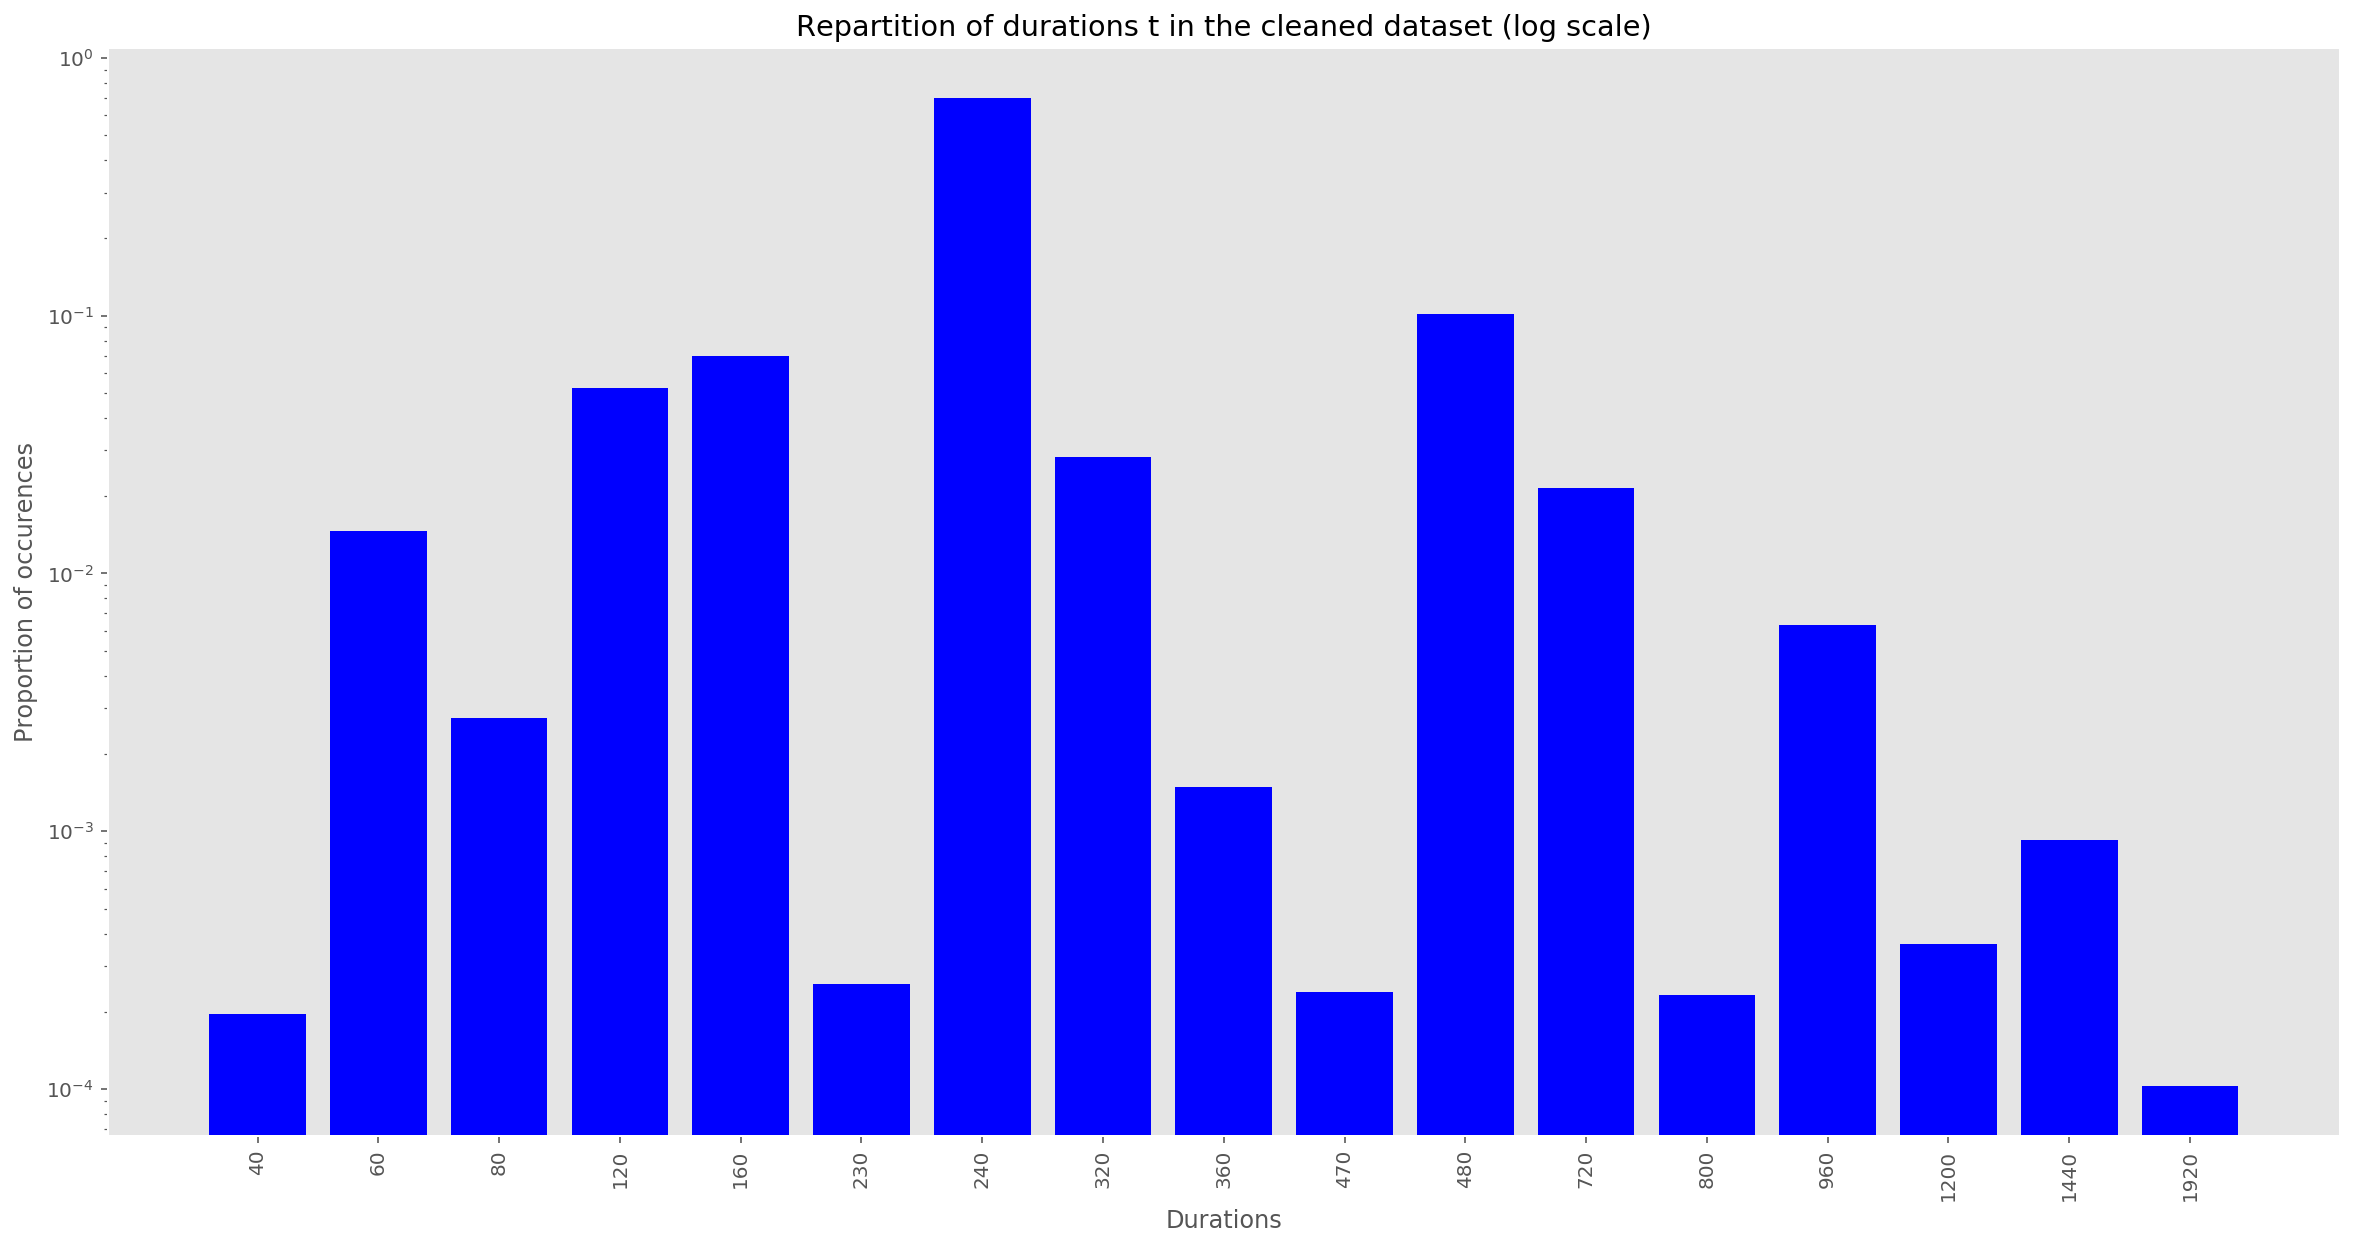

In [11]:
_ = histogram_duration(cleaned_dataset, "T", "Repartition of durations t in the cleaned dataset (log scale)")

### Pitch Normalization:

Counter({72: 77338, 65: 58556, 67: 53756, 73: 49844, 68: 48526, 77: 44983, 69: 41974, 70: 41009, 64: 40047, 74: 37711, 60: 35985, 75: 35829, 76: 32778, 62: 30019, 63: 29127, 61: 29039, 71: 27902, 66: 21288, 79: 17743, 80: 17455, 78: 13584, 82: 9603, 81: 9055, 84: 7467, 57: 7105, 59: 6896, 58: 6543, 55: 6189, 56: 5835, 85: 3981, 83: 3094, 53: 1318, 87: 1098, 86: 1036, 52: 730, 54: 457, 89: 388, 50: 352, 88: 300, 51: 265, 49: 264, 48: 248, 90: 37, 92: 13, 91: 12, 94: 6, 93: 2})


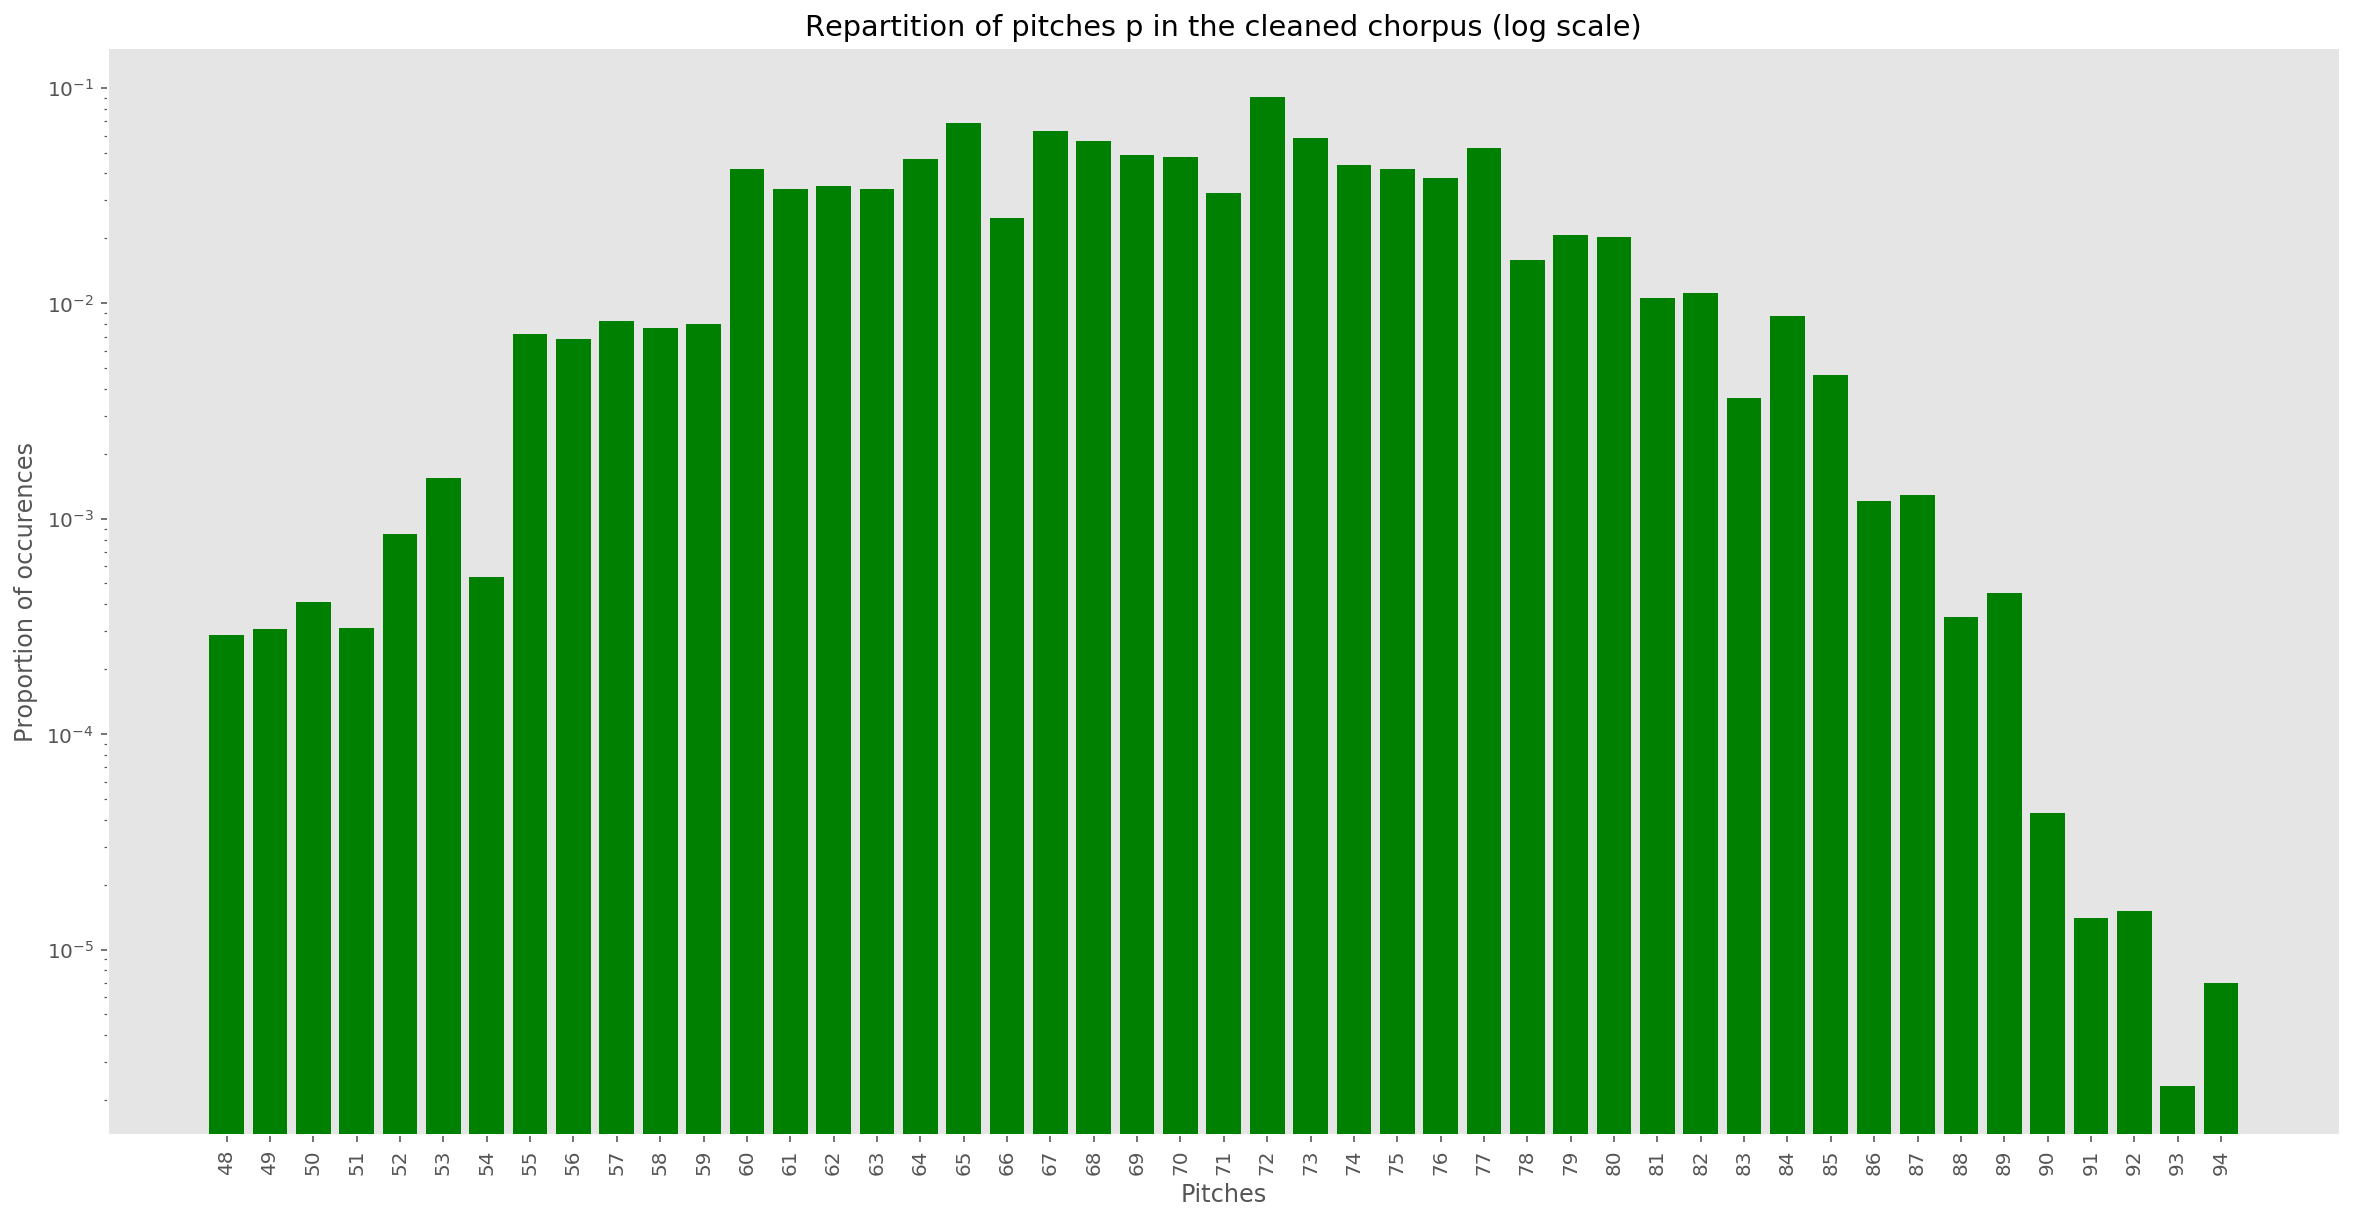

In [12]:
_ = histogram_duration(cleaned_dataset, 'P', "Repartition of pitches p in the cleaned chorpus (log scale)", color = "green")

In [13]:
def transposeDataset(dataset):
    transposed_dataset = {}
    
    for i, label in enumerate(list(dataset.keys())):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [14]:
transposed_dataset = transposeDataset(cleaned_dataset)

Counter({72: 98412, 67: 96736, 64: 79813, 69: 75175, 76: 68121, 74: 66547, 60: 61325, 62: 55176, 71: 47876, 65: 37944, 79: 34285, 81: 23416, 77: 21300, 55: 15175, 57: 13603, 59: 12624, 84: 10696, 83: 9287, 86: 4199, 78: 3340, 70: 3013, 52: 2740, 53: 2368, 66: 2270, 88: 2247, 58: 1889, 50: 1259, 48: 1042, 68: 1012, 80: 611, 73: 472, 63: 423, 75: 398, 61: 332, 91: 254, 54: 219, 90: 214, 56: 175, 85: 171, 93: 160, 82: 117, 89: 88, 46: 73, 51: 39, 43: 38, 45: 36, 95: 33, 87: 13, 96: 12, 92: 7, 98: 6, 47: 4, 94: 2})


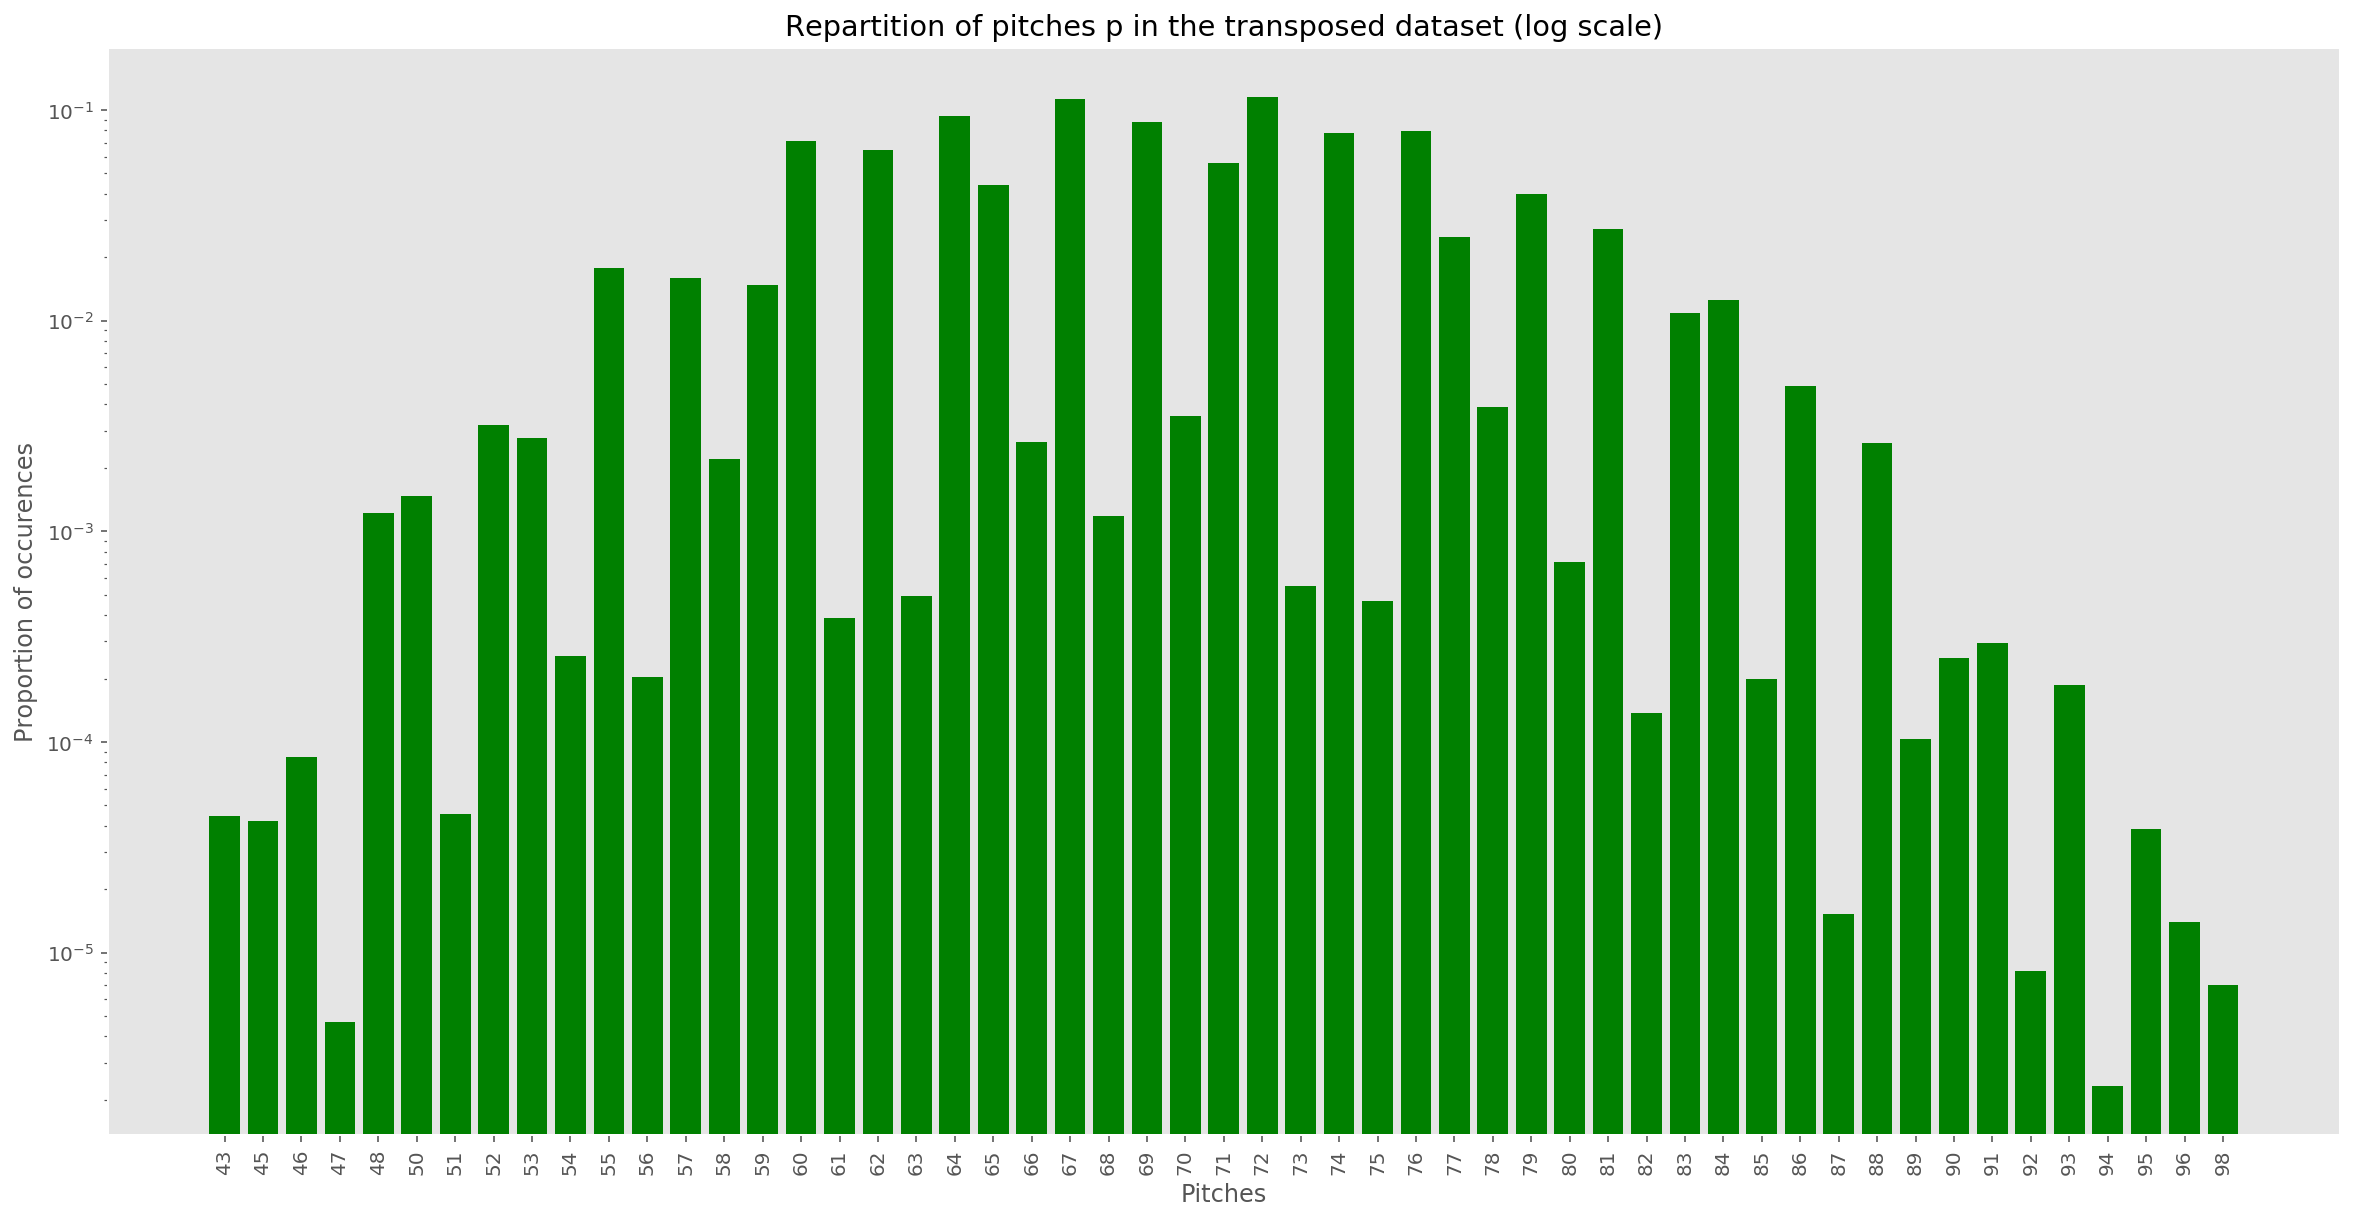

In [15]:
_ = histogram_duration(transposed_dataset, 'P', "Repartition of pitches p in the transposed dataset (log scale)", color = "green")


pt_dict, inverse_dict, transposed_int = to_int(transposed_dataset)
save_obj(inverse_dict, "inverse_dict")
save_obj(transposed_int, "transposed_int")

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: The space of durations got reduced from 63 to 17 with the rare event suppression procedure ! The training time of the network might be reduced as we only need 17 neurons as input and output (instead of 63) for the duration. Thus lots of connections between input and hidden layers and between hidden layers and the output layer are removed that reduces the training time.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: With melodies transposed to a single tonality, there are some pitches more occurent than others, as we can see in the two pitches repartition histograms: before transposition the pitches between 62 and 82 are moreless equally distributed whereas after the transposition, there are less pitches that appear more (looks like a normal distribution with pitch 69 as the center -> C Major which is the pitch to which we transposed). 
With all possibile tonalities, we would have way more data with the same number of melodies in each tonality. By training the model with all these data, it might learn to know the tonality of a specific song and thus the notes that occur more in the specific tonality might occur more often.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: Keeping the joint representation would have gave us: number of distinct pitches (53) times the number of distinct durations (17) = 901 dimensions instead of 53 + 17 = 70 that we have now. The network would have taken a lot more time to train plus some of the 901 possibilities wouldn't have make sense: maybe a specific pitch combined with a specific duration does not even exist in the whole corpus.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: As explained in the previous question some combinations of specific duration and pitch might not even exist in the chorpus. Their distribution would thus be 0. Moreover, in the actual duration repartition, we observe that the duration 240 is very important (approximately 60% of notes) and the durations 120, 160 and 480 have mostly the rest of the repartiotion (approximately 25%), thus with the joint model, 85% of notes would be contained in the combination with duration 120, 160, 240, 480 -> 53 * 4 = 212 possibilities over 901. The rest of the 689 possibilities would have really low repartition.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [54]:
inverse_dict = load_obj("inverse_dict")
transposed_int = load_obj("transposed_int")

import statistics
lengths = [len(melody["T"]) for label, melody in transposed_int.items()]
max_length = int(statistics.mean(lengths) + 2*statistics.stdev(lengths))
print("Maximum length: {}".format(max_length))

def to_tensors(dataset):
    labels = []
    pitches = []
    durations = []
    pitches_one_hot = []
    durations_one_hot = []
    
    for label, melody in dataset.items():
        labels.append(label)
        pitches.append(melody["P"])
        durations.append(melody["T"])
    
    pitch_range = max([max(p) for p in pitches])+1
    duration_range = max([max(d) for d in durations])+1
    
    # ONE-HOT ENCODING
    for p in pitches:
        one_hot = np_utils.to_categorical(p, num_classes=pitch_range)
        pitches_one_hot.append(one_hot)
        
    for t in durations:
        one_hot = np_utils.to_categorical(t, num_classes=duration_range)
        durations_one_hot.append(one_hot)
        
    # ZERO PADDING
    pitches_one_hot_zero_pad = np.empty((len(pitches_one_hot), max_length, pitch_range))
    durations_one_hot_zero_pad = np.empty((len(durations_one_hot), max_length, duration_range))
    for i, pitch_melody in enumerate(pitches_one_hot):
        # pitch_melody and duration_melody are of same lengths
        duration_melody = durations_one_hot[i]
        if len(pitch_melody) < max_length:
            # Add vectors of zeros, such that the total melody is of size max_length
            nbr_rows = max_length - len(pitch_melody)
            pitch_zero_pad = np.zeros((nbr_rows, pitch_range))
            duration_zero_pad = np.zeros((nbr_rows, duration_range))
            pitches_one_hot_zero_pad[i] = np.concatenate((pitch_melody, pitch_zero_pad))
            durations_one_hot_zero_pad[i] = np.concatenate((duration_melody, duration_zero_pad))
        else:
            # Remove last vectors such that the total melody is of size max_length
            pitches_one_hot_zero_pad[i] = pitch_melody[:max_length]
            durations_one_hot_zero_pad[i] = duration_melody[:max_length]
        
    return labels, pitches_one_hot_zero_pad, durations_one_hot_zero_pad

Maximum length: 403


In [55]:
labels, pitches, durations = to_tensors(transposed_int)
save_obj(labels, "labels")
save_obj(pitches, "pitches")
save_obj(durations, "durations")

In [57]:
print("Shape of pitches melodies: {}".format(np.shape(pitches)))
print("Shape of durations melodies: {}".format(np.shape(durations)))

Shape of pitches melodies: (4442, 403, 53)
Shape of durations melodies: (4442, 403, 17)


Before one hot / zero pad
length of melody: 106


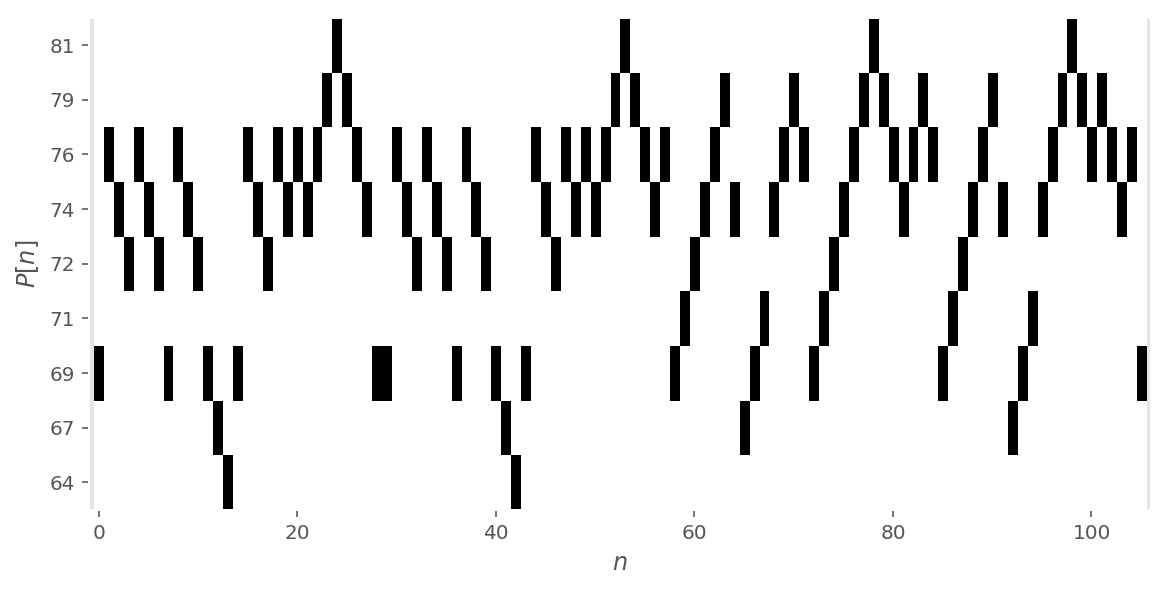

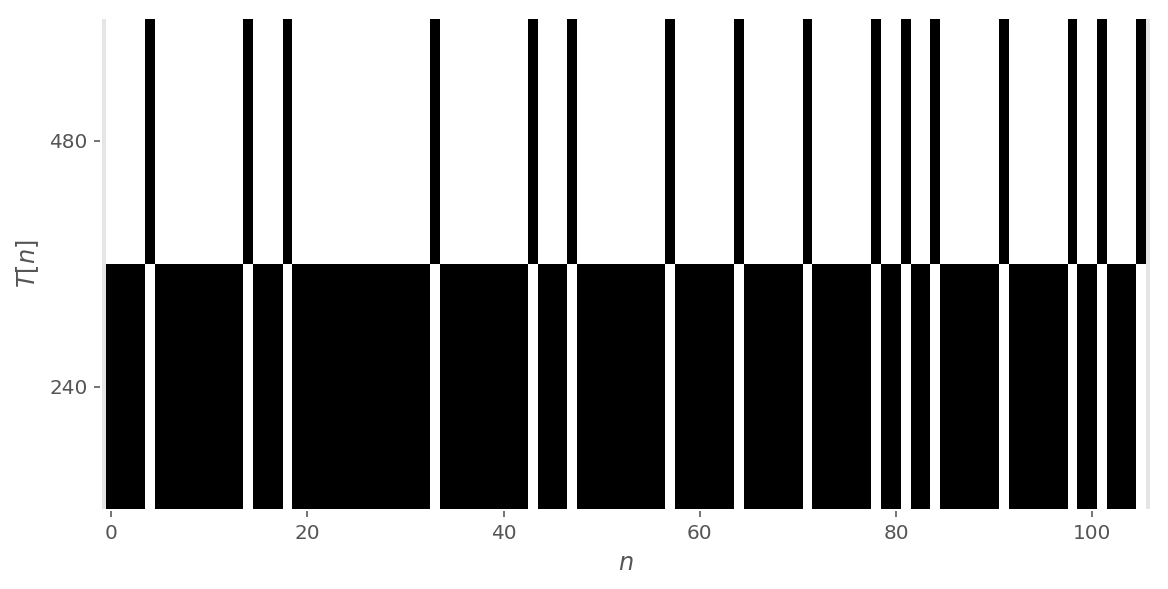

After one hot / zero pad
length of melody after one hot / zero pad: 403


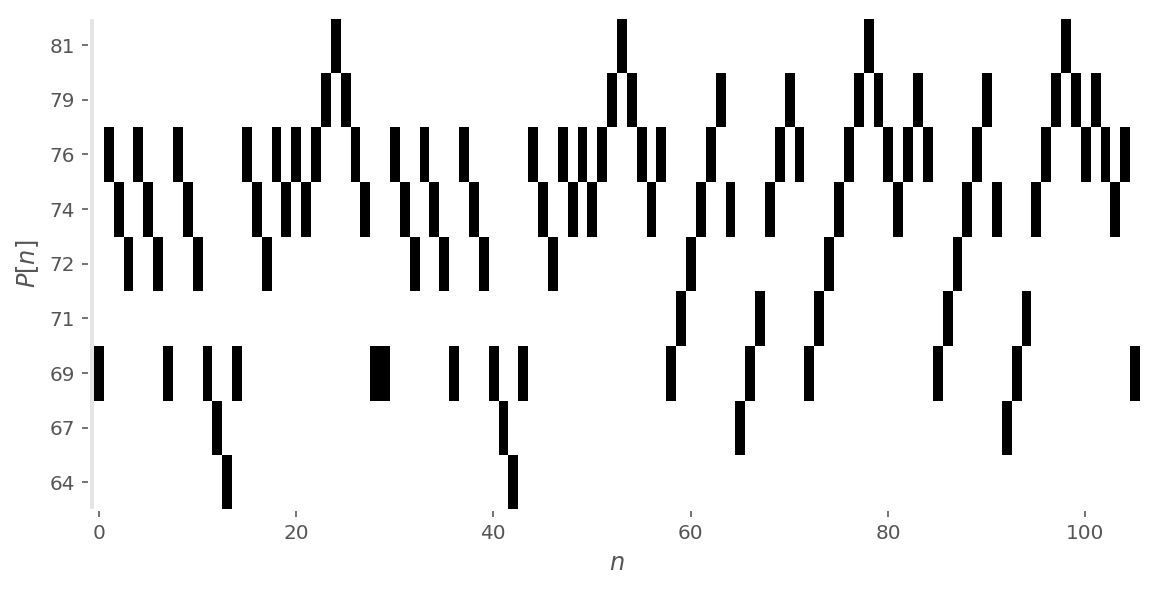

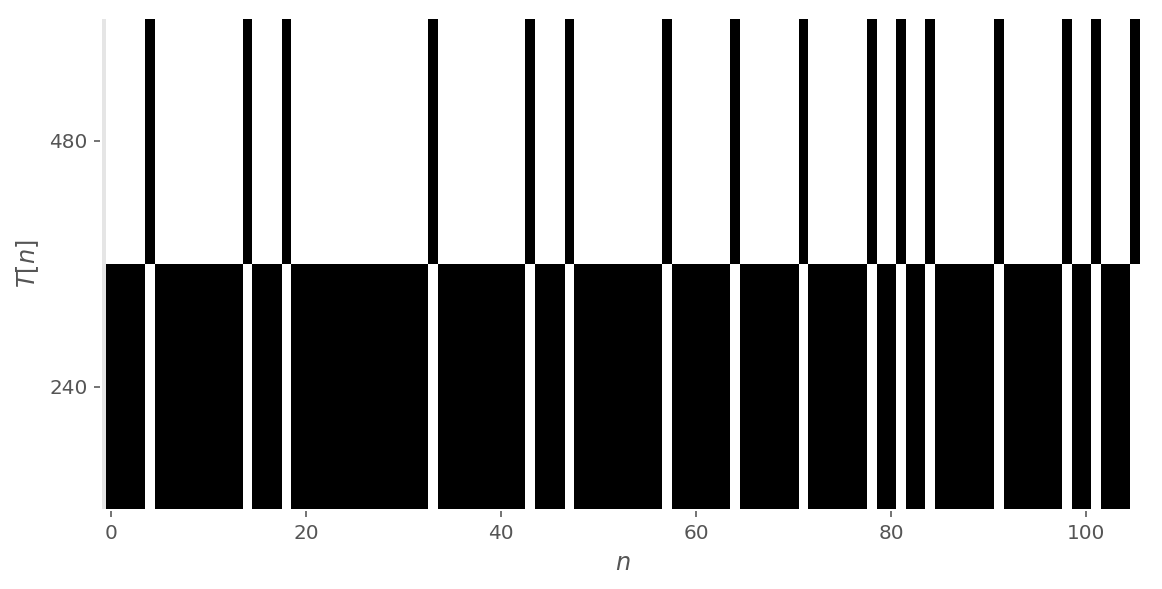

Before one hot / zero pad
length of melody: 262


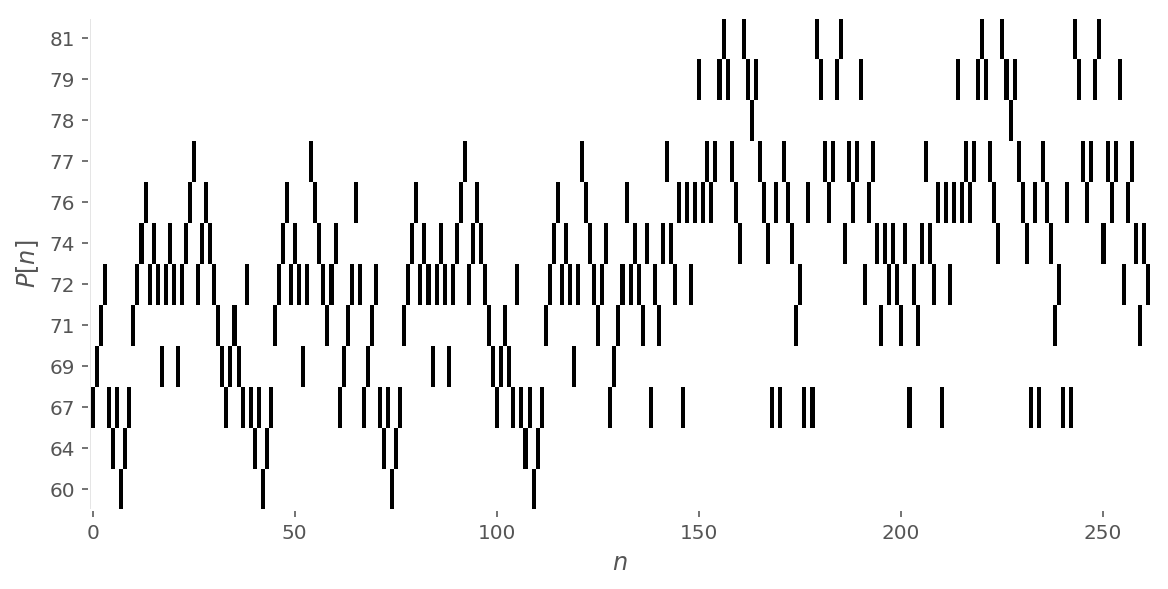

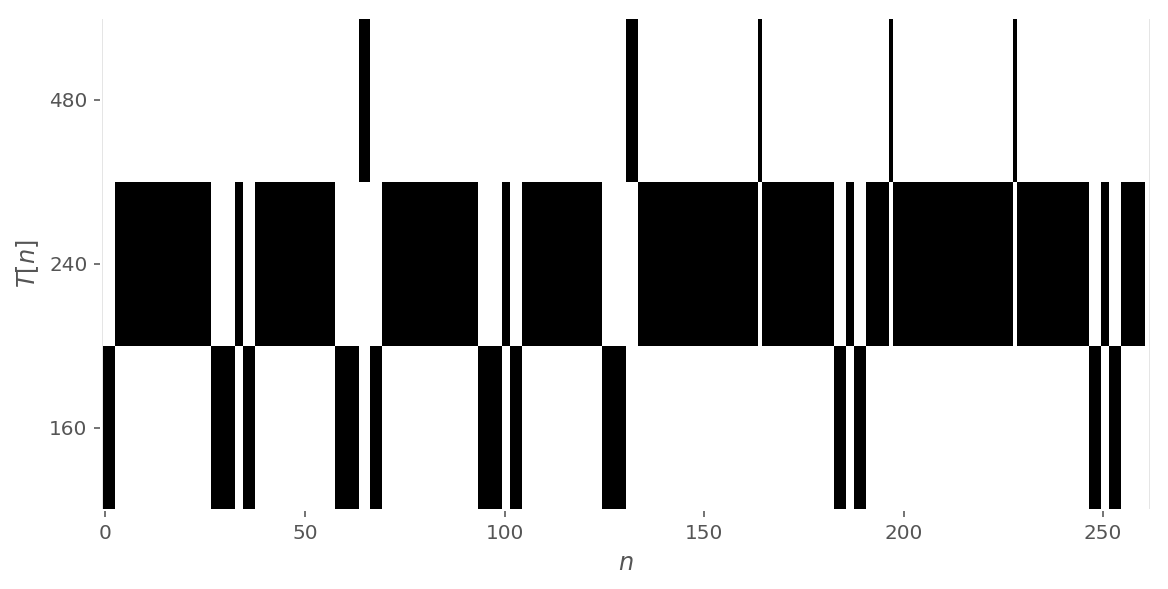

After one hot / zero pad
length of melody after one hot / zero pad: 403


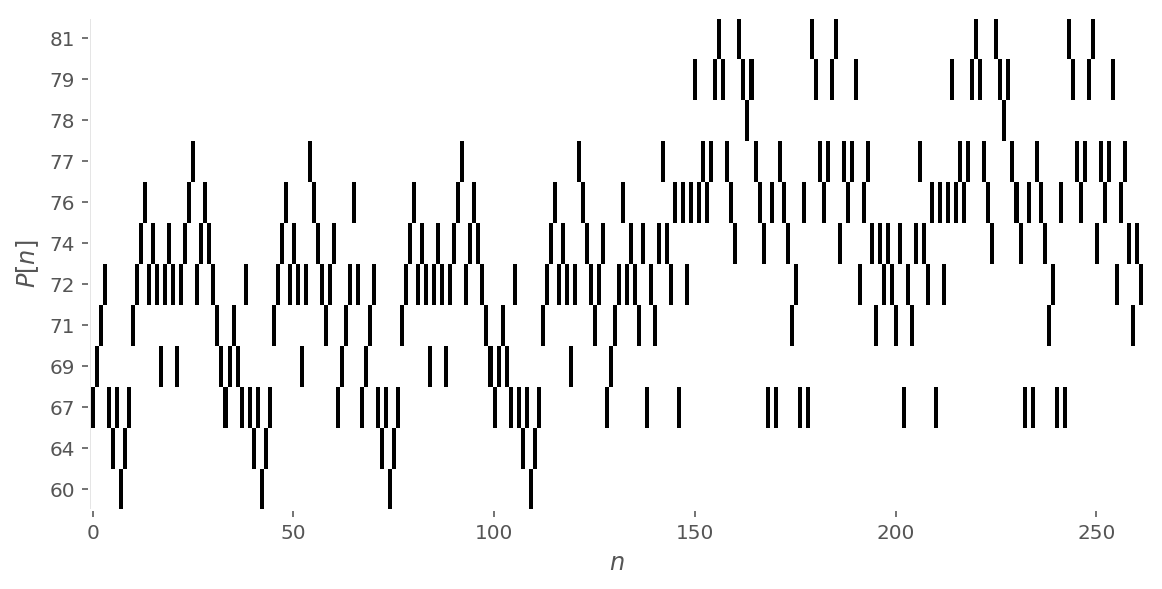

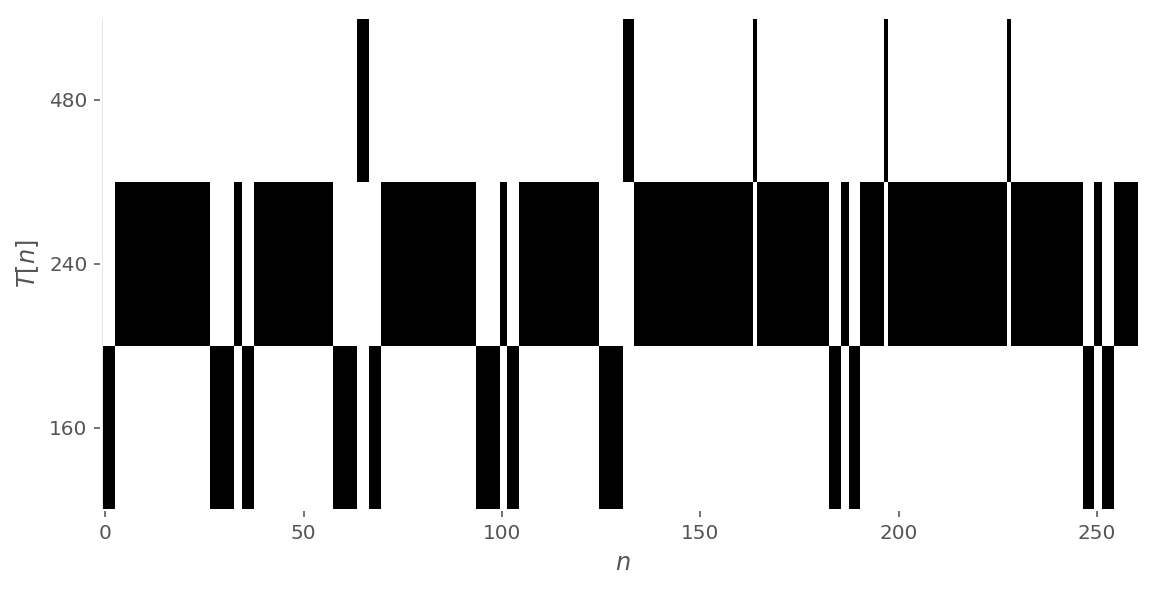

In [63]:
# Testing correctness of pitches and durations
for label in np.random.choice(range(len(pitches)), 2):
    melody = transposed_int[labels[label]]
    print("Before one hot / zero pad")
    print("length of melody: {}".format(len(melody["P"])))
    plotMelody(melody["P"], melody["T"], inverse_dict)
    print("After one hot / zero pad")
    print("length of melody after one hot / zero pad: {}".format(len(pitches[label])))
    plotMelody(pitches[label], durations[label], inverse_dict)

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [4]:
labels = load_obj("labels")
pitches = load_obj("pitches")
durations = load_obj("durations")

inverse_dict = load_obj("inverse_dict")
transposed_int = load_obj("transposed_int")

import statistics
lengths = [len(melody["T"]) for label, melody in transposed_int.items()]
max_length = int(statistics.mean(lengths) + 2*statistics.stdev(lengths))

In [7]:
import random

def split(pitches, durations, hidden_states = False):
    # Create the training and testing randomly
    random_list = list(range(len(labels)))
    random.shuffle(random_list)
    split_index = int(len(random_list)*0.8)
    
    indices_train = random_list[:split_index]
    indices_test = random_list[split_index:]
    
    pitch_range = len(inverse_dict["P"])
    duration_range = len(inverse_dict["T"])
    X_pitches = np.empty((len(labels), max_length - 1, pitch_range))
    X_durations =  np.empty((len(labels), max_length - 1, duration_range))
    Y_pitches =  np.empty((len(labels), max_length - 1, pitch_range))
    Y_durations =  np.empty((len(labels), max_length - 1, duration_range))
    
    for i in range(len(labels)):
        # For the Xs don't take the last note as we want to predict it and need
        X_p = pitches[i][:-1]
        X_pitches[i] = X_p
        X_t = durations[i][:-1]
        X_durations[i] = X_t
        
        # The y consists of the Xs melodies shifted by one:
        Y_p = pitches[i][1:]
        Y_pitches[i] = Y_p
        Y_t = durations[i][1:]
        Y_durations[i] = Y_t
    
    x_train = {"XP": X_pitches[indices_train], "XT": X_durations[indices_train]}
    x_val = {"XP": X_pitches[indices_test], "XT": X_durations[indices_test]}
    
    y_train = {"YP": Y_pitches[indices_train], "YT": Y_durations[indices_train]}
    y_val = {"YP": Y_pitches[indices_test], "YT": Y_durations[indices_test]}
    
    return y_train, x_train, y_val, x_val

In [8]:
y_train, x_train, y_val, x_val = split(pitches, durations)

In [30]:
# Check that the y and x are correct for a random melody:
print(x_train["XT"][18][43])
print(y_train["YT"][18][42])

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [11]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128, with_weights=None):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    t = None
    p = None
    if activation == 'GRU':
        H['T'] = GRU(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)(H["1"])
        H['P'] = GRU(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)(H["1"])
        #Your hidden layer(s) architecture with GRU
    elif activation == 'LSTM':
        pass
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
    elif activation == 'RNN':
        H['T'] = SimpleRNN(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)(H["1"])
        H['P'] = SimpleRNN(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)(H["1"])
        #Your hidden layer(s) architecture with SimpleRNN

    if with_weights is None:
        Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['T'])
        Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['P'])
        output = [Y['T'], Y['P']]
    else:
        output = [H['T'], H['P']]
        
    model = Model(inputs = [X['T'], X['P']], outputs = output)
    opt = Adam() 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    
    if with_weights is not None:
        model.set_weights(with_weights)
    
    
    return model

In [12]:
def early_stopping_values(history):
    """Compute maximal accuracy in history and return corresponding accuracy for pitch and duration"""
    index_pitch = np.array(history["val_YP_acc"]).argmax()
    index_duration = np.array(history["val_YT_acc"]).argmax()
    early_acc_pitch = history["val_YP_acc"][index_pitch]
    early_acc_duration = history["val_YT_acc"][index_duration]
    return early_acc_pitch, early_acc_duration

In [13]:
def get_best_model(activation, dropouts_list = [0.2, 0.3, 0.4]):
    """Given the activation function (GRU, RSTM, RNN), create and fit the corresponding model for different dropout ratio
    and return the model giving the maximal accuracy (mean of best pitch and best duration accuracy)"""
    best_history = None
    best_model = None
    best_acc = 0
    best_dropout = 0
    for i, dropout in enumerate(dropouts_list):
        print("DROPOUT = {}".format(dropout))
        model1 = buildModel(inverse_dict, batch_length = max_length-1, dropout = dropout, activation=activation)
        history1 = model1.fit(x_train, y_train, epochs=250, verbose=1, validation_data=(x_val, y_val))
        save_obj(history1.history, "history_"+ activation + "_" + str(i + 1))
        acc_pitch, acc_duration = early_stopping_values(history1.history)
        mean_acc = (acc_pitch + acc_duration) / 2
        # Use mean accuracy to select the best model
        if best_acc < mean_acc:
            best_acc = mean_acc
            best_history = history1
            best_model = model1
            best_dropout = dropout
    print("Best dropout ratio: {} giving best accuracy: {}".format(best_dropout, best_acc))
    return best_model, best_history, best_dropout        

Compute best RNN depending on value of dropout:

In [61]:
model_RNN, history_RNN, best_drop = get_best_model("RNN")
save_obj(history_RNN.history, "history_RNN")
model_RNN.save('BEST_model_RNN.h5')

DROPOUT = 0.2
Train on 3553 samples, validate on 889 samples
Epoch 1/250
3553/3553 [==============================] - 57s 16ms/step - loss: 4.0861 - YT_loss: 1.2177 - YP_loss: 2.8684 - YT_acc: 0.6719 - YP_acc: 0.1349 - val_loss: 3.5526 - val_YT_loss: 0.9724 - val_YP_loss: 2.5802 - val_YT_acc: 0.6886 - val_YP_acc: 0.1916
Epoch 2/250
3553/3553 [==============================] - 53s 15ms/step - loss: 3.3230 - YT_loss: 0.9378 - YP_loss: 2.3853 - YT_acc: 0.7286 - YP_acc: 0.2313 - val_loss: 2.9422 - val_YT_loss: 0.8259 - val_YP_loss: 2.1163 - val_YT_acc: 0.7525 - val_YP_acc: 0.2886
Epoch 3/250
3553/3553 [==============================] - 152s 43ms/step - loss: 3.0248 - YT_loss: 0.8564 - YP_loss: 2.1684 - YT_acc: 0.7547 - YP_acc: 0.2663 - val_loss: 2.7737 - val_YT_loss: 0.7821 - val_YP_loss: 1.9916 - val_YT_acc: 0.7702 - val_YP_acc: 0.3085
Epoch 4/250
3553/3553 [==============================] - 59s 17ms/step - loss: 2.9231 - YT_loss: 0.8298 - YP_loss: 2.0933 - YT_acc: 0.7604 - YP_acc: 0.2802

3553/3553 [==============================] - 54s 15ms/step - loss: 2.6225 - YT_loss: 0.6970 - YP_loss: 1.9255 - YT_acc: 0.7936 - YP_acc: 0.3267 - val_loss: 2.4195 - val_YT_loss: 0.6244 - val_YP_loss: 1.7951 - val_YT_acc: 0.8119 - val_YP_acc: 0.3704
Epoch 33/250
3553/3553 [==============================] - 54s 15ms/step - loss: 2.6220 - YT_loss: 0.6948 - YP_loss: 1.9272 - YT_acc: 0.7953 - YP_acc: 0.3265 - val_loss: 2.4096 - val_YT_loss: 0.6187 - val_YP_loss: 1.7909 - val_YT_acc: 0.8115 - val_YP_acc: 0.3734
Epoch 34/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.6316 - YT_loss: 0.7090 - YP_loss: 1.9226 - YT_acc: 0.7917 - YP_acc: 0.3272 - val_loss: 2.4071 - val_YT_loss: 0.6215 - val_YP_loss: 1.7856 - val_YT_acc: 0.8135 - val_YP_acc: 0.3737
Epoch 35/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.6089 - YT_loss: 0.6915 - YP_loss: 1.9173 - YT_acc: 0.7958 - YP_acc: 0.3297 - val_loss: 2.4149 - val_YT_loss: 0.6144 - val_YP_loss: 1.8005 - val_Y

3553/3553 [==============================] - 53s 15ms/step - loss: 2.5235 - YT_loss: 0.6385 - YP_loss: 1.8851 - YT_acc: 0.8042 - YP_acc: 0.3388 - val_loss: 2.2961 - val_YT_loss: 0.5564 - val_YP_loss: 1.7398 - val_YT_acc: 0.8191 - val_YP_acc: 0.3900
Epoch 95/250
3553/3553 [==============================] - 54s 15ms/step - loss: 2.5286 - YT_loss: 0.6496 - YP_loss: 1.8790 - YT_acc: 0.8015 - YP_acc: 0.3409 - val_loss: 2.2984 - val_YT_loss: 0.5574 - val_YP_loss: 1.7411 - val_YT_acc: 0.8226 - val_YP_acc: 0.3887
Epoch 96/250
3553/3553 [==============================] - 52s 15ms/step - loss: 2.5294 - YT_loss: 0.6452 - YP_loss: 1.8842 - YT_acc: 0.8025 - YP_acc: 0.3386 - val_loss: 2.2970 - val_YT_loss: 0.5545 - val_YP_loss: 1.7425 - val_YT_acc: 0.8213 - val_YP_acc: 0.3874
Epoch 97/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.5183 - YT_loss: 0.6394 - YP_loss: 1.8789 - YT_acc: 0.8034 - YP_acc: 0.3414 - val_loss: 2.3213 - val_YT_loss: 0.5875 - val_YP_loss: 1.7337 - val_Y

3553/3553 [==============================] - 53s 15ms/step - loss: 2.5133 - YT_loss: 0.6432 - YP_loss: 1.8701 - YT_acc: 0.8017 - YP_acc: 0.3426 - val_loss: 2.3013 - val_YT_loss: 0.5615 - val_YP_loss: 1.7399 - val_YT_acc: 0.8189 - val_YP_acc: 0.3890
Epoch 157/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.5287 - YT_loss: 0.6422 - YP_loss: 1.8865 - YT_acc: 0.8034 - YP_acc: 0.3383 - val_loss: 2.3157 - val_YT_loss: 0.5713 - val_YP_loss: 1.7444 - val_YT_acc: 0.8173 - val_YP_acc: 0.3840
Epoch 158/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.5834 - YT_loss: 0.7031 - YP_loss: 1.8803 - YT_acc: 0.7921 - YP_acc: 0.3399 - val_loss: 2.3314 - val_YT_loss: 0.6021 - val_YP_loss: 1.7292 - val_YT_acc: 0.8155 - val_YP_acc: 0.3899
Epoch 159/250
3553/3553 [==============================] - 54s 15ms/step - loss: 2.5644 - YT_loss: 0.6916 - YP_loss: 1.8728 - YT_acc: 0.7943 - YP_acc: 0.3425 - val_loss: 2.3558 - val_YT_loss: 0.5881 - val_YP_loss: 1.7677 - va

3553/3553 [==============================] - 56s 16ms/step - loss: 2.5308 - YT_loss: 0.6601 - YP_loss: 1.8707 - YT_acc: 0.8016 - YP_acc: 0.3427 - val_loss: 2.2904 - val_YT_loss: 0.5625 - val_YP_loss: 1.7279 - val_YT_acc: 0.8200 - val_YP_acc: 0.3949
Epoch 219/250
3553/3553 [==============================] - 52s 15ms/step - loss: 2.5149 - YT_loss: 0.6523 - YP_loss: 1.8627 - YT_acc: 0.8021 - YP_acc: 0.3467 - val_loss: 2.2902 - val_YT_loss: 0.5704 - val_YP_loss: 1.7198 - val_YT_acc: 0.8201 - val_YP_acc: 0.3945
Epoch 220/250
3553/3553 [==============================] - 54s 15ms/step - loss: 2.5293 - YT_loss: 0.6607 - YP_loss: 1.8686 - YT_acc: 0.7999 - YP_acc: 0.3448 - val_loss: 2.2863 - val_YT_loss: 0.5628 - val_YP_loss: 1.7234 - val_YT_acc: 0.8206 - val_YP_acc: 0.3938
Epoch 221/250
3553/3553 [==============================] - 53s 15ms/step - loss: 2.5335 - YT_loss: 0.6649 - YP_loss: 1.8686 - YT_acc: 0.8000 - YP_acc: 0.3453 - val_loss: 2.2984 - val_YT_loss: 0.5728 - val_YP_loss: 1.7256 - va

C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


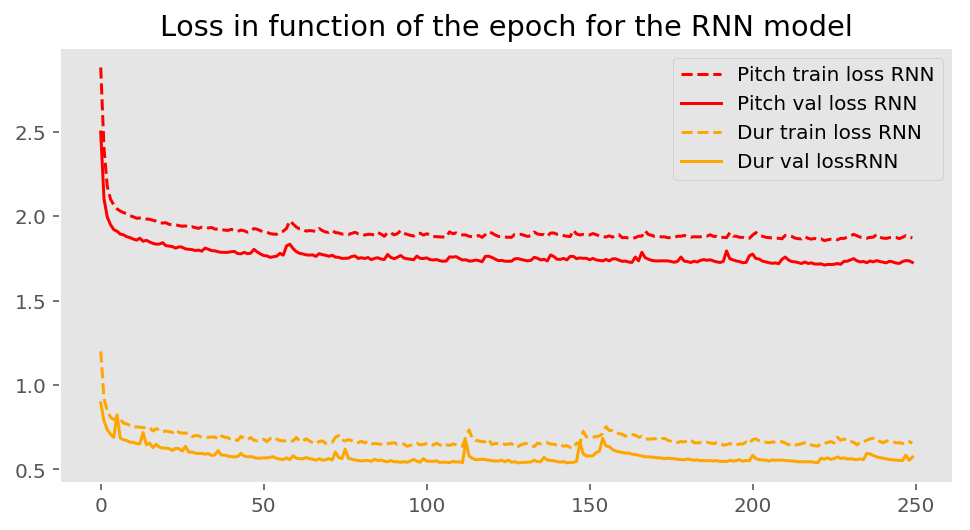

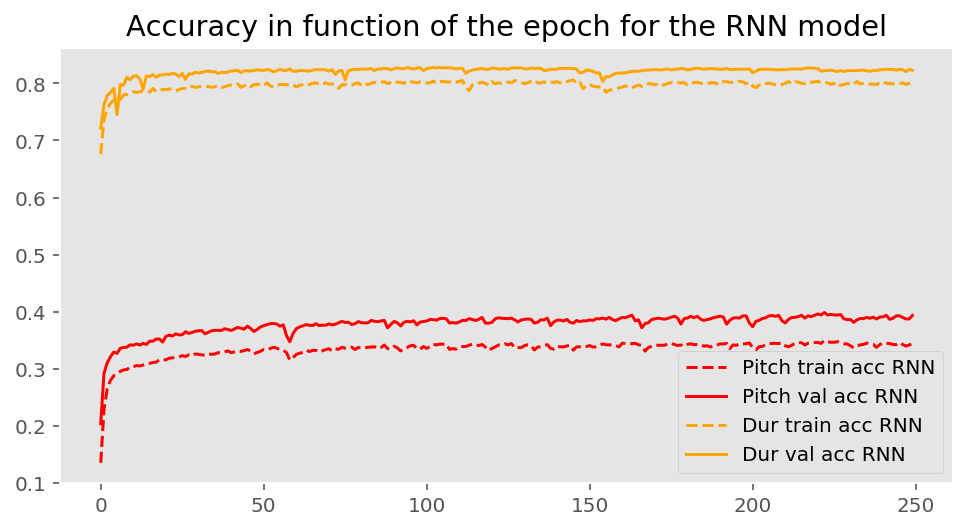

In [39]:
history_RNN = load_obj("history_RNN")
model_RNN = load_model("BEST_model_RNN.h5") 
plotLearningCurves(history_RNN, activation1 = "RNN")

Compute best GRU depending on value of dropout:

In [ ]:
model_GRU, history_GRU, _ = get_best_model("GRU", [0.2])
save_obj(history_GRU.history, "history_GRU")
model_GRU.save('BEST_model_GRU.h5')

DROPOUT = 0.2
Train on 3553 samples, validate on 889 samples
Epoch 1/250
3553/3553 [==============================] - 136s 38ms/step - loss: 3.9808 - YT_loss: 1.2372 - YP_loss: 2.7436 - YT_acc: 0.6887 - YP_acc: 0.1893 - val_loss: 3.0083 - val_YT_loss: 0.7859 - val_YP_loss: 2.2224 - val_YT_acc: 0.7690 - val_YP_acc: 0.2702
Epoch 2/250
3553/3553 [==============================] - 133s 37ms/step - loss: 2.9805 - YT_loss: 0.8353 - YP_loss: 2.1452 - YT_acc: 0.7514 - YP_acc: 0.2675 - val_loss: 2.7252 - val_YT_loss: 0.7031 - val_YP_loss: 2.0221 - val_YT_acc: 0.7818 - val_YP_acc: 0.3004
Epoch 3/250
3553/3553 [==============================] - 135s 38ms/step - loss: 2.8074 - YT_loss: 0.7717 - YP_loss: 2.0357 - YT_acc: 0.7667 - YP_acc: 0.2886 - val_loss: 2.6230 - val_YT_loss: 0.6687 - val_YP_loss: 1.9543 - val_YT_acc: 0.7920 - val_YP_acc: 0.3212
Epoch 4/250
3553/3553 [==============================] - 144s 41ms/step - loss: 2.7372 - YT_loss: 0.7468 - YP_loss: 1.9904 - YT_acc: 0.7727 - YP_acc: 0.3

C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


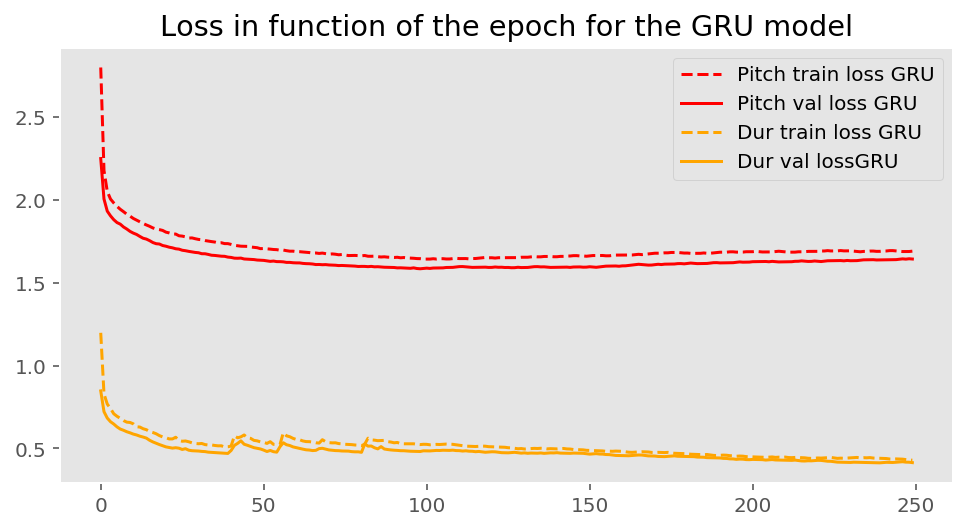

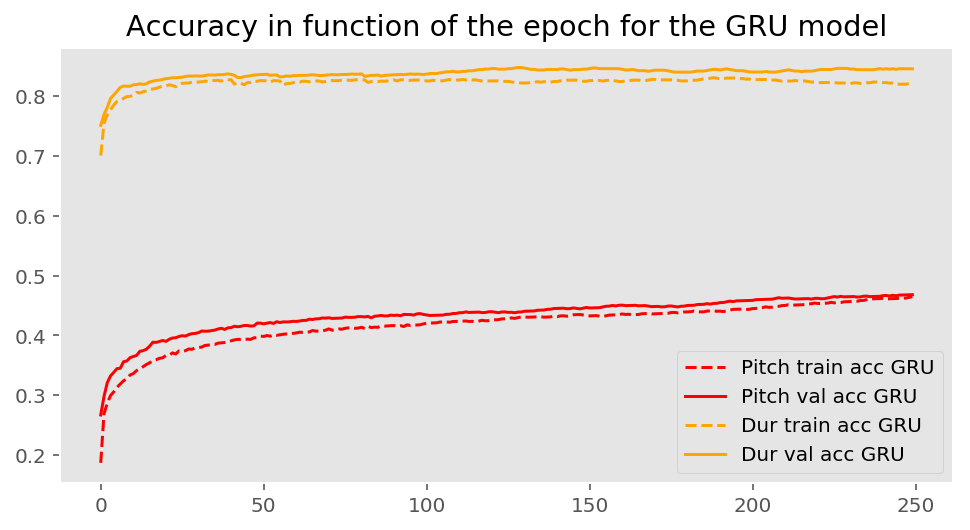

In [45]:
history_GRU = load_obj("history_GRU")
model_GRU = load_model("BEST_model_GRU.h5") 
plotLearningCurves(history_GRU, activation1 = "GRU")

C:\Users\olivi\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


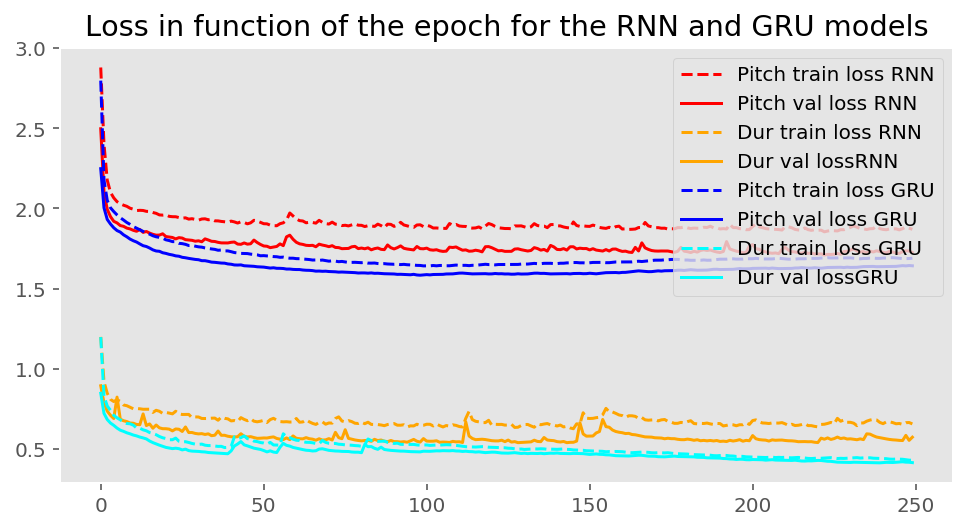

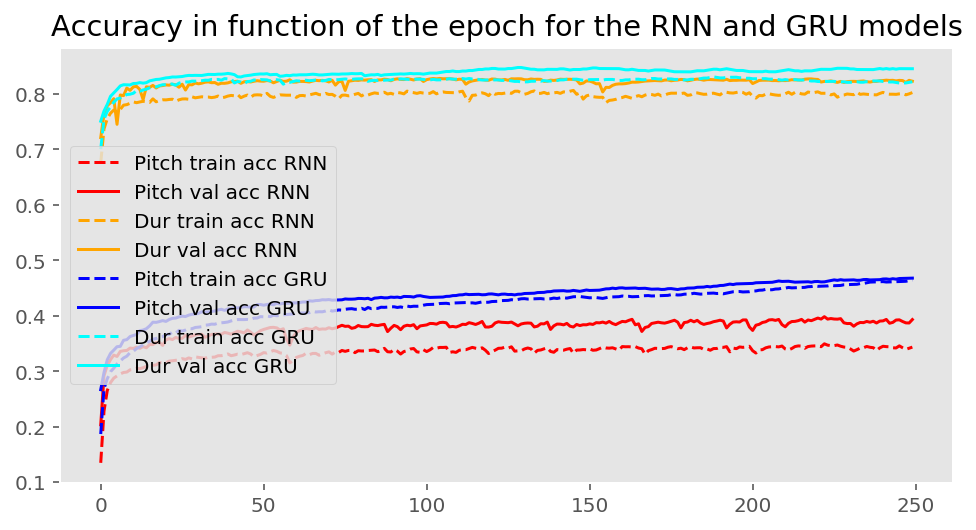

In [46]:
plotLearningCurves(history_RNN, History2=history_GRU, activation1 = "RNN", activation2 = "GRU")

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: The best prediction accuracy we got was with GRU, we got around 0.44 validation accuracy for the pitches and 0.83 validation accuracy for the durations.

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: From the plots, we see that GRU learns faster and better. Both are pretty stable and don't overfit over time. For both model, we see that the loss is decreasing rapidly at the beginning and then stagnating (from 100th epoch) whereas the accuracies are fastly increasing at the beginning and then slowly increasing / stagnating (around 30th epoch)



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

1. and 2.:

In [9]:
def print_acc(predicted_T, predicted_P):
    """Function that computes the predictions of pitches and duration given a specific model and also gives the accuracy of the predictions"""
    """Compute pitches and durations predictions"""

    # We need to convert the matrices of predictions as does the softmax method (max of each row set to 1 and rest to 0)
    pred_T = np.zeros_like(predicted_T)
    pred_T[np.arange(len(predicted_T)), predicted_T.argmax(1)] = 1
    pred_P = np.zeros_like(predicted_P)
    pred_P[np.arange(len(predicted_P)), predicted_P.argmax(1)] = 1
    
    # Compute accuracy between the 2 models for pitch
    count_same_P = 0
    for i, row in enumerate(pred_P):
        actual = P[0][i]
        same_pitch = True
        for j, elem in enumerate(row):
            if elem != actual[j]:
                same_pitch = False
        if same_pitch:
            count_same_P += 1
    accuracy_P = count_same_P / len(pred_P)

    # Compute accuracy for the duration
    count_same_T = 0
    for i, row in enumerate(pred_T):
        actual = T[0][i]
        same_duration = True
        for j, elem in enumerate(row):
            if elem != actual[j]:
                same_duration = False
        if same_duration:
            count_same_T += 1
    accuracy_T = count_same_T / len(pred_T)

    print("Accuracy for pitch: {} , Accuracy for duration: {}".format(accuracy_P, accuracy_T))
        
    return pred_P, pred_T

In [14]:
modified_RNN = buildModel(inverse_dict, batch_length=max_length-1, dropout=0.2, \
                                activation="RNN", with_weights=model_RNN.get_weights()[:-4])
modified_GRU = buildModel(inverse_dict, batch_length=max_length-1, dropout=0.2, \
                                activation="GRU", with_weights=model_GRU.get_weights()[:-4])

Melody at index 3277
Accuracy for pitch: 0.014925373134328358 , Accuracy for duration: 0.41044776119402987


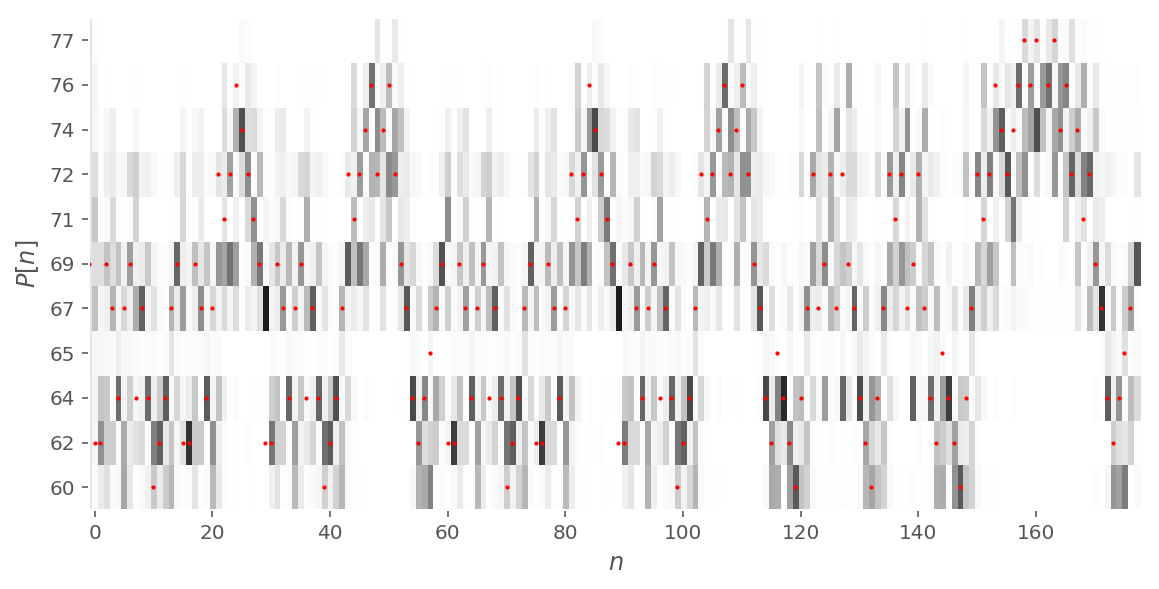

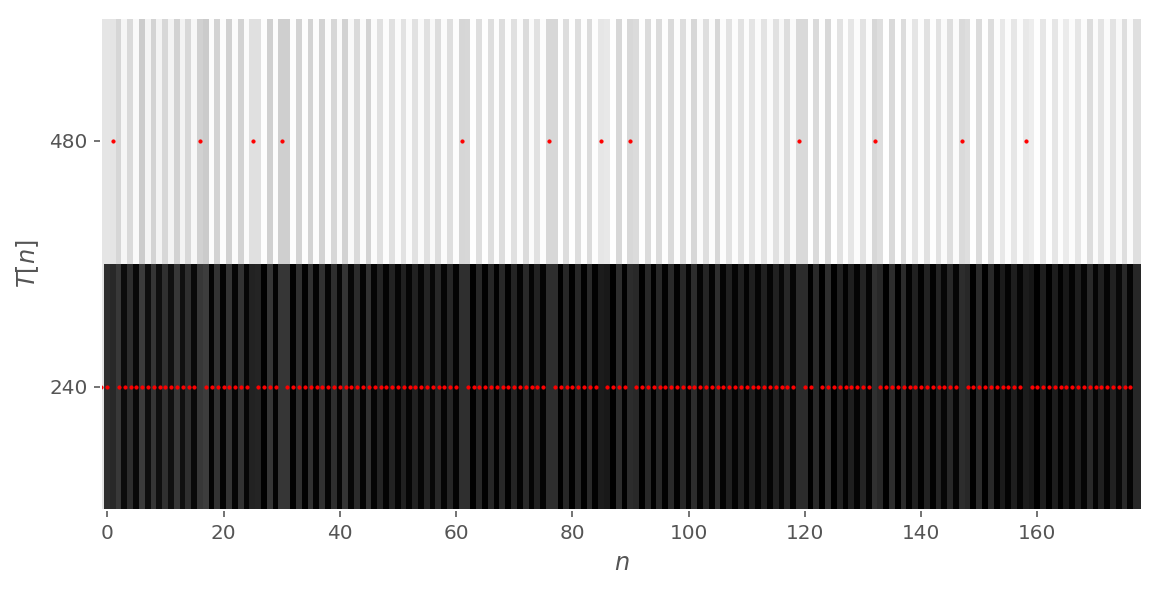

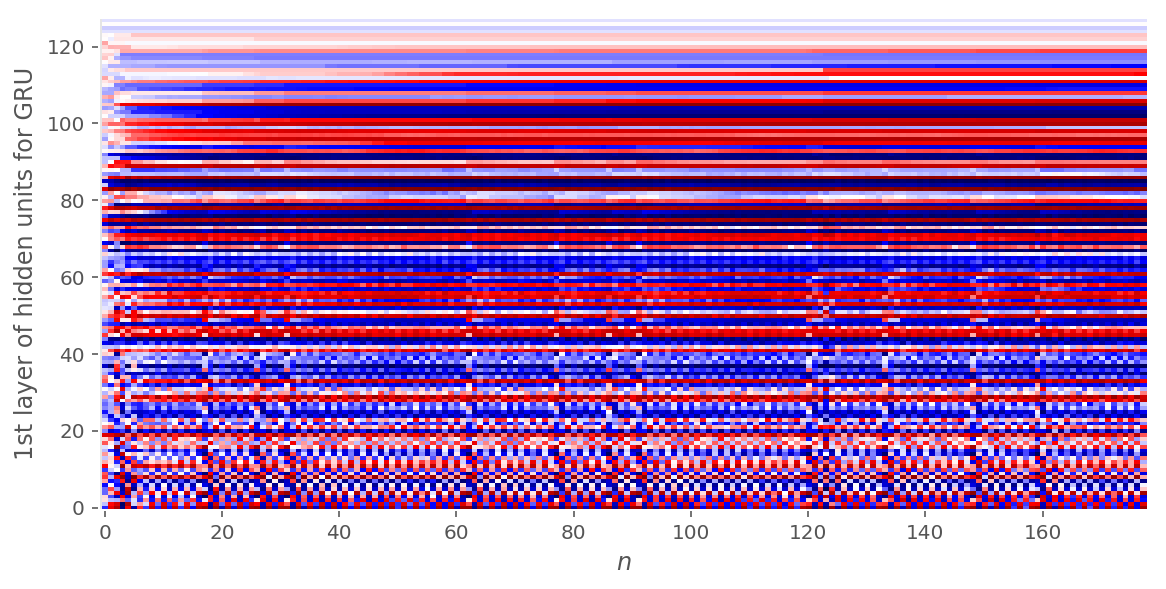

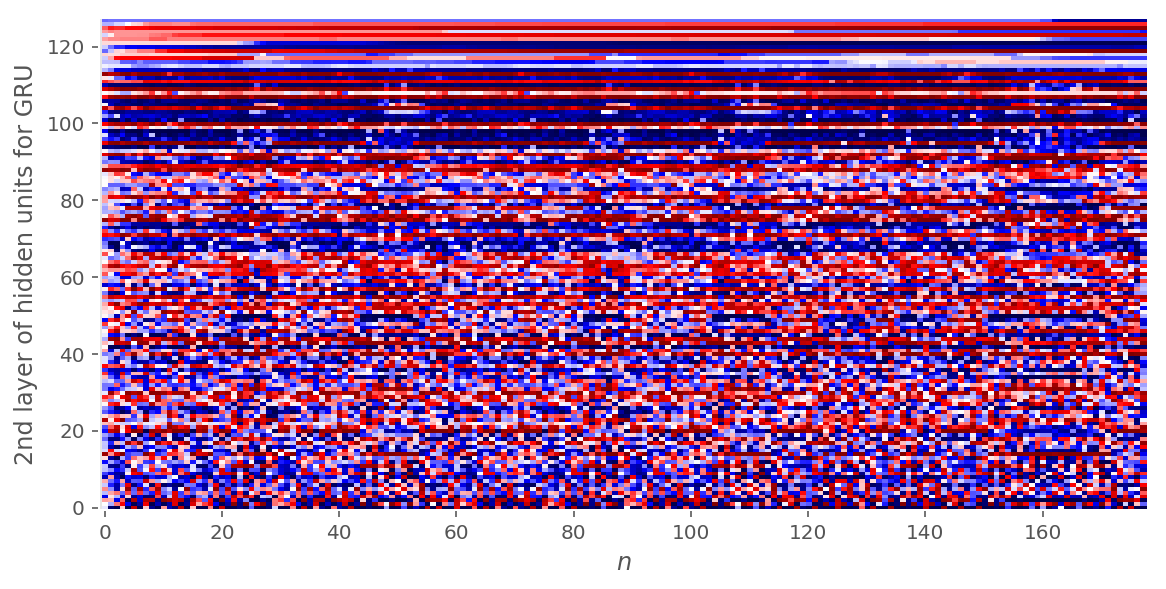

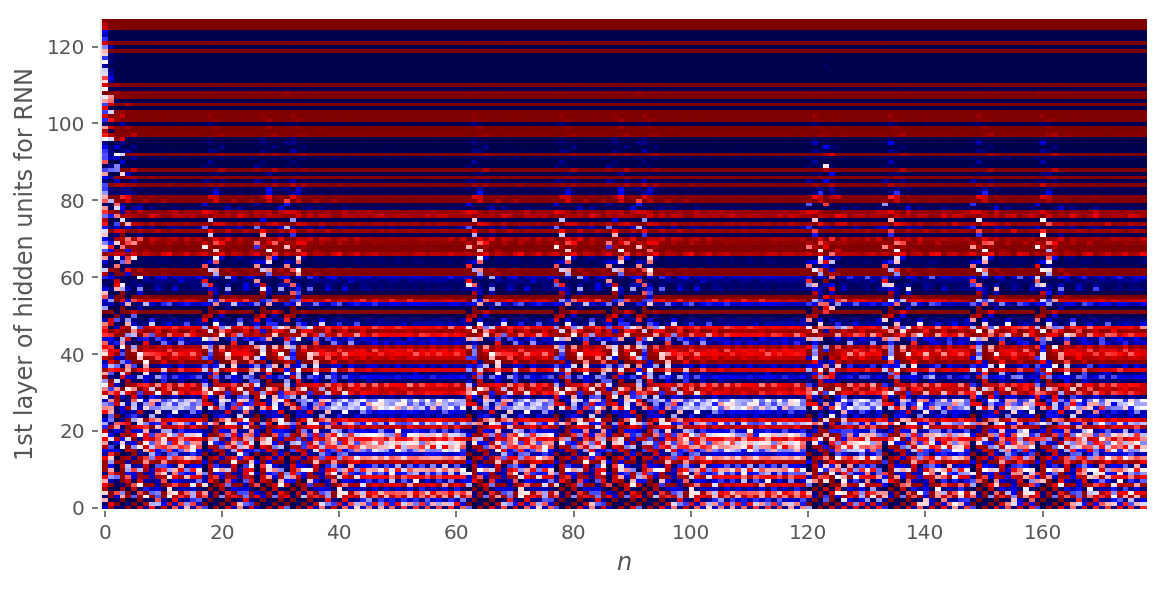

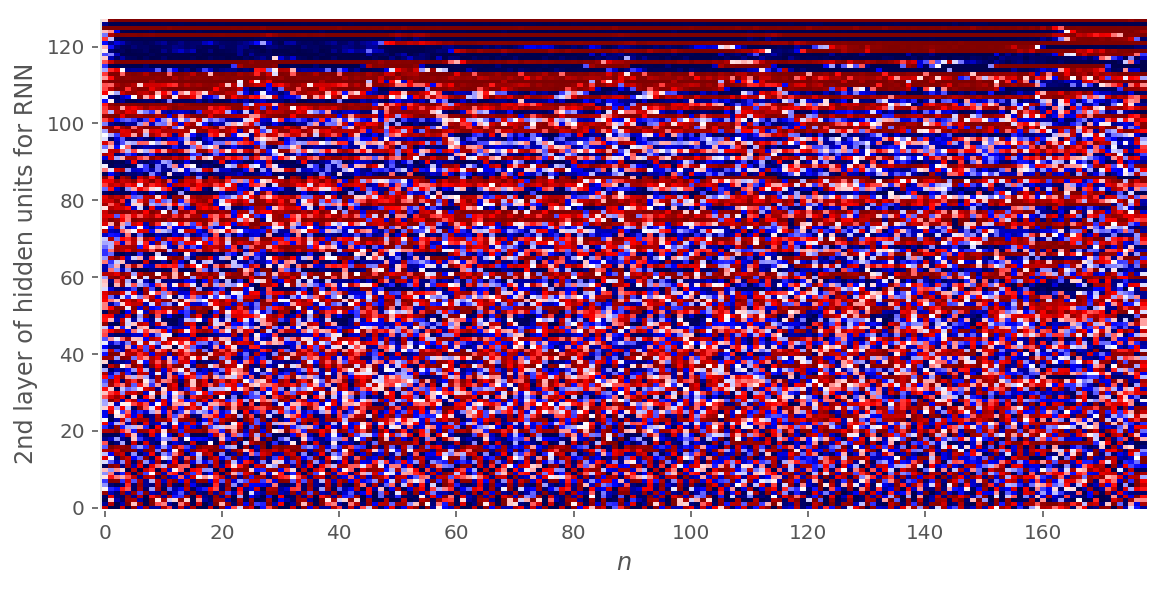

Melody at index 2477
Accuracy for pitch: 0.012437810945273632 , Accuracy for duration: 0.3283582089552239


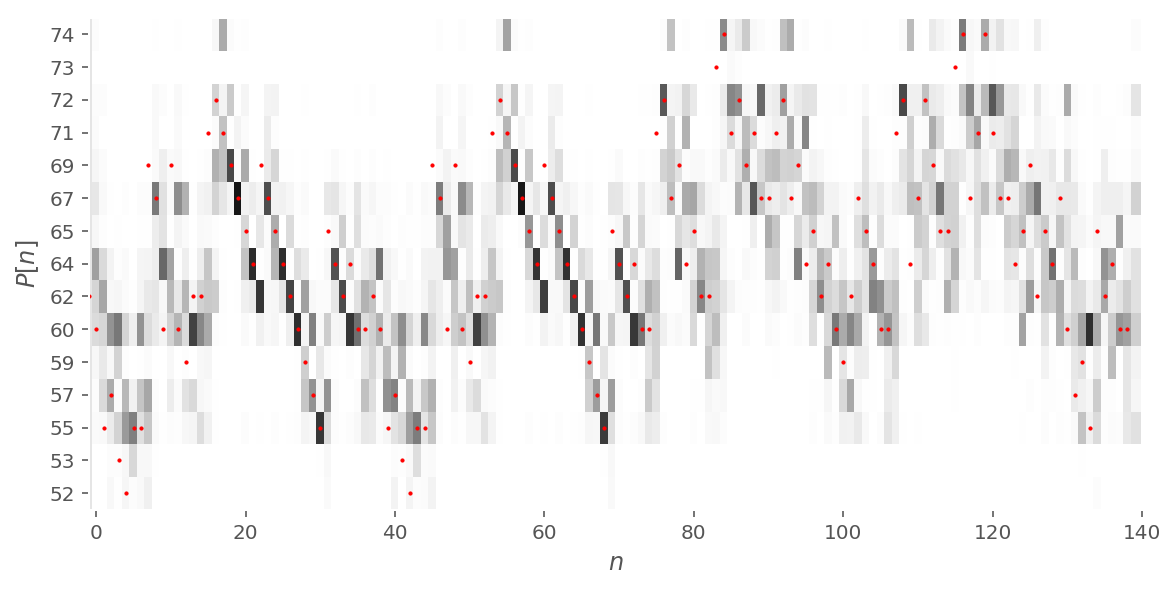

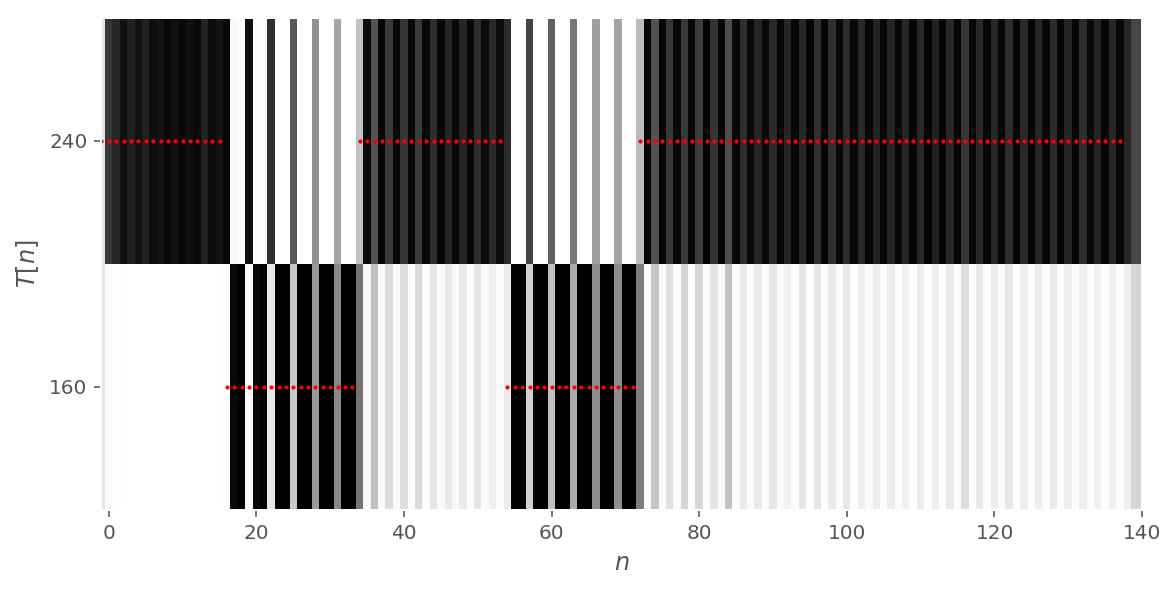

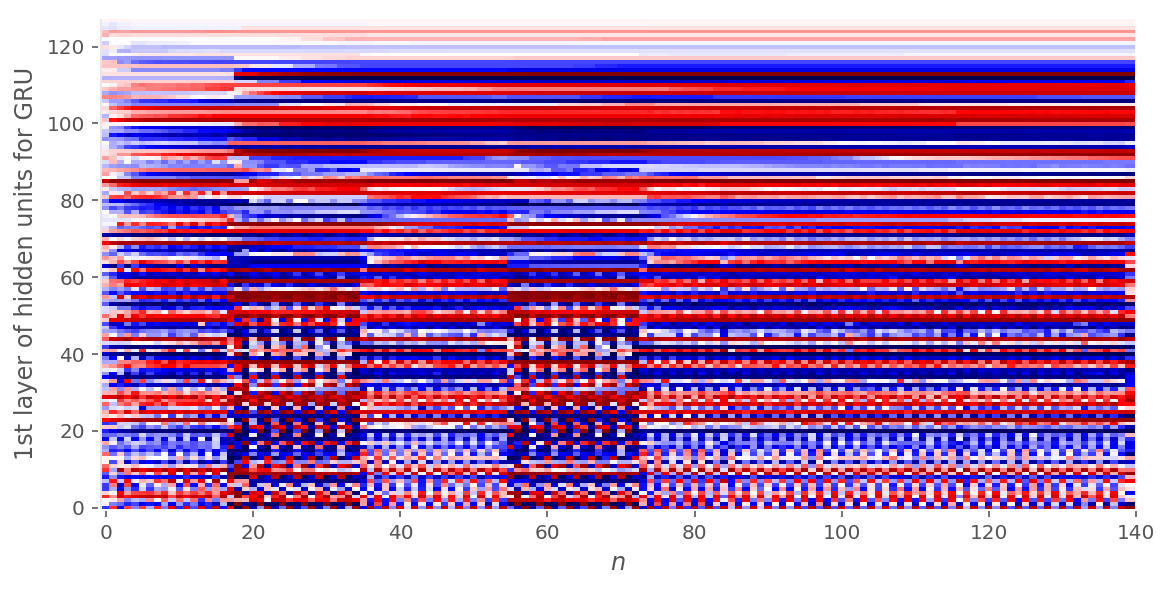

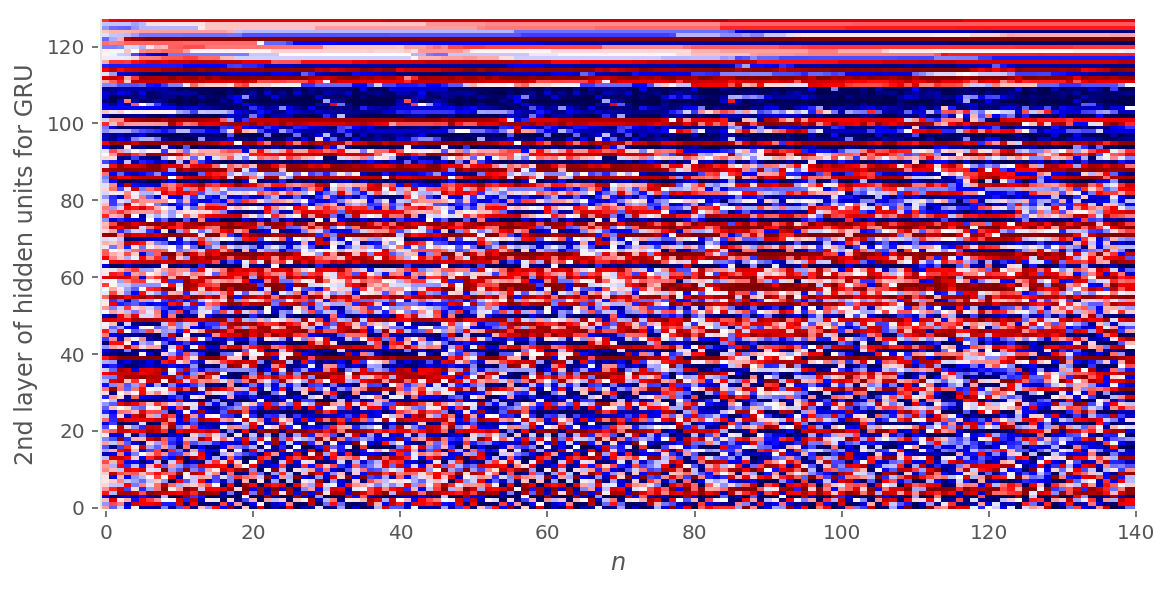

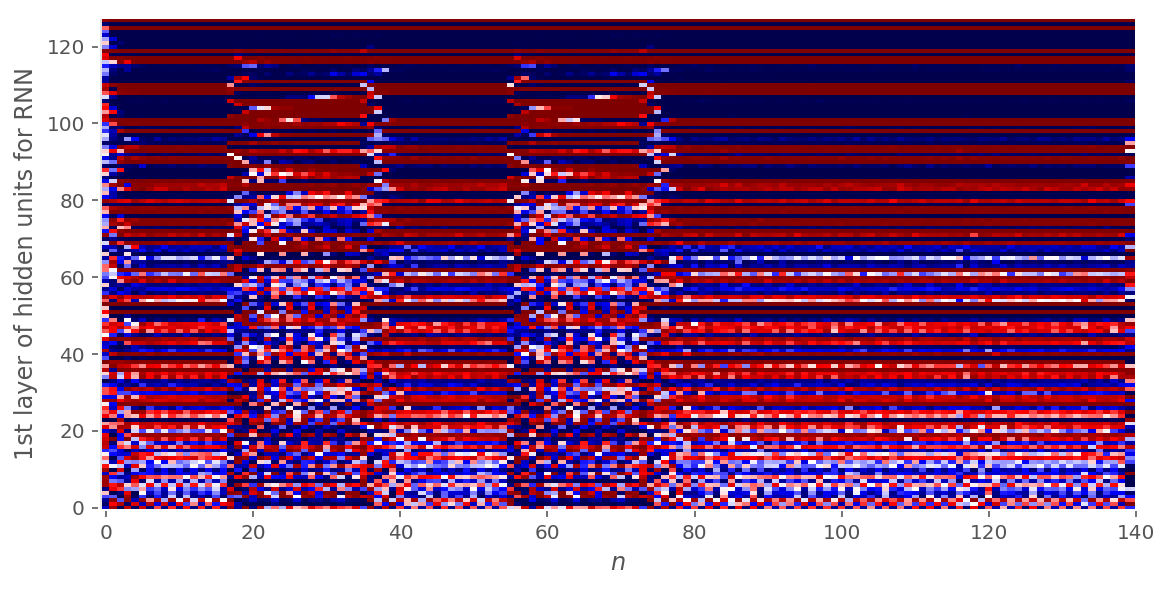

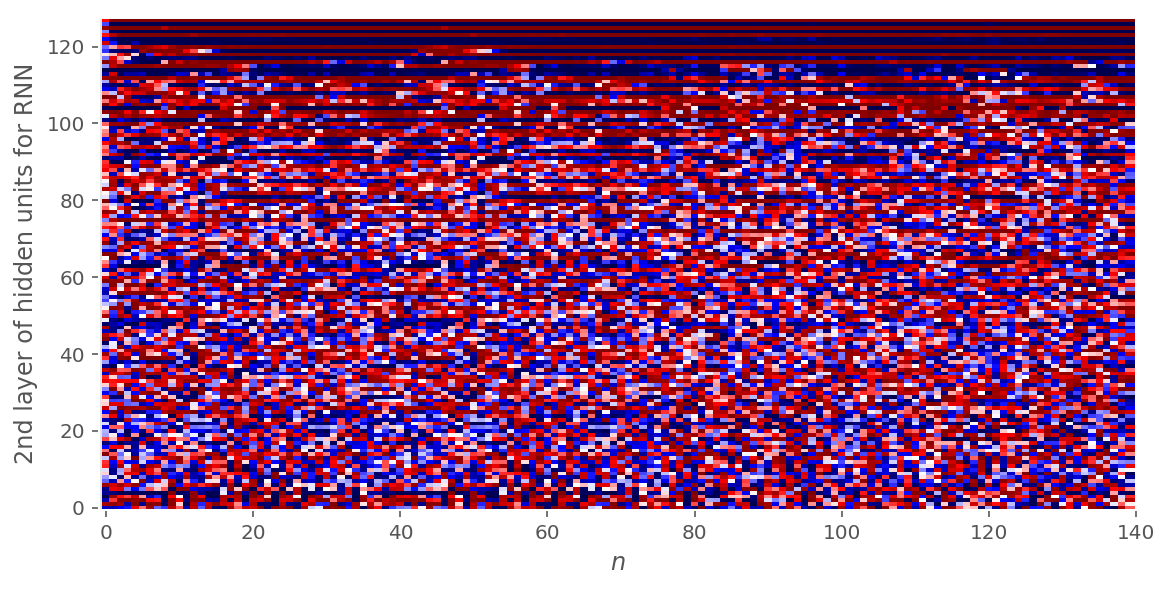

Melody at index 1922
Accuracy for pitch: 0.014925373134328358 , Accuracy for duration: 0.38308457711442784


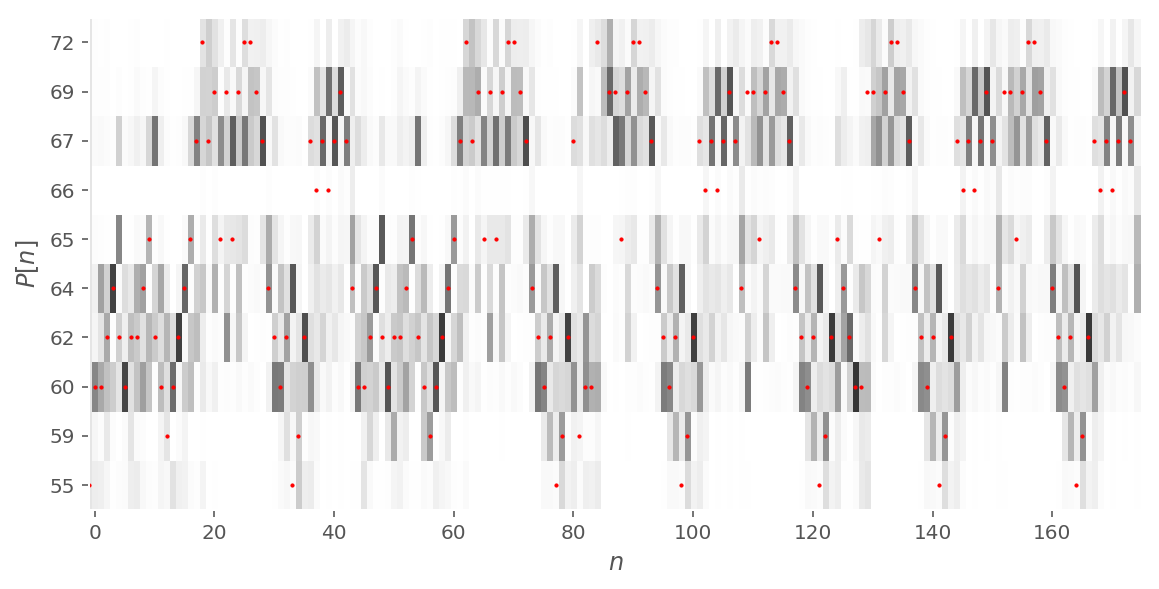

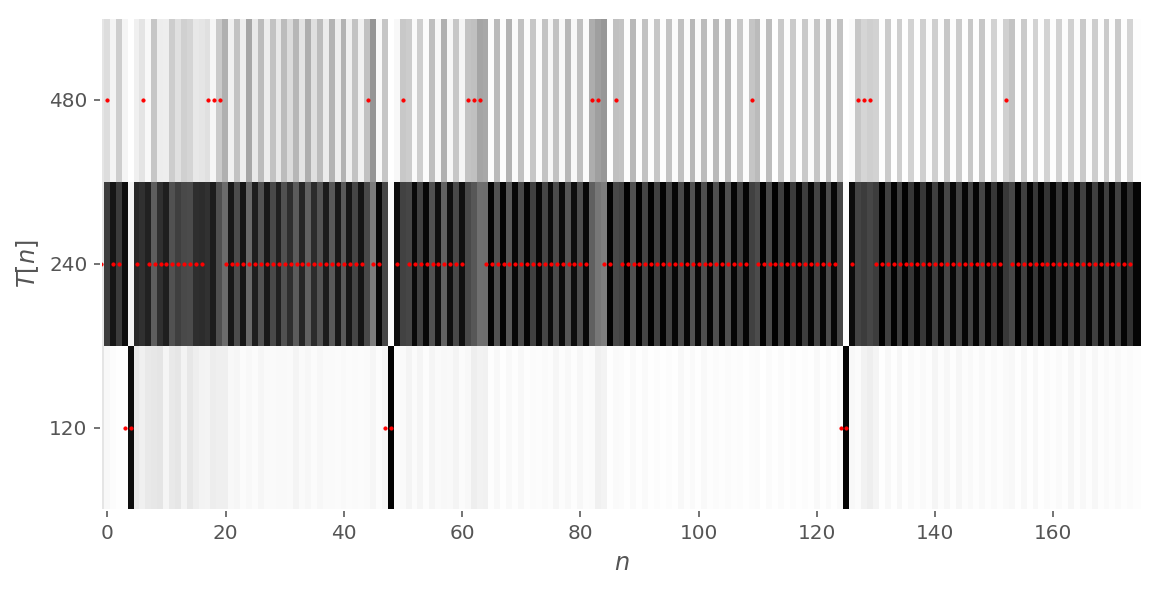

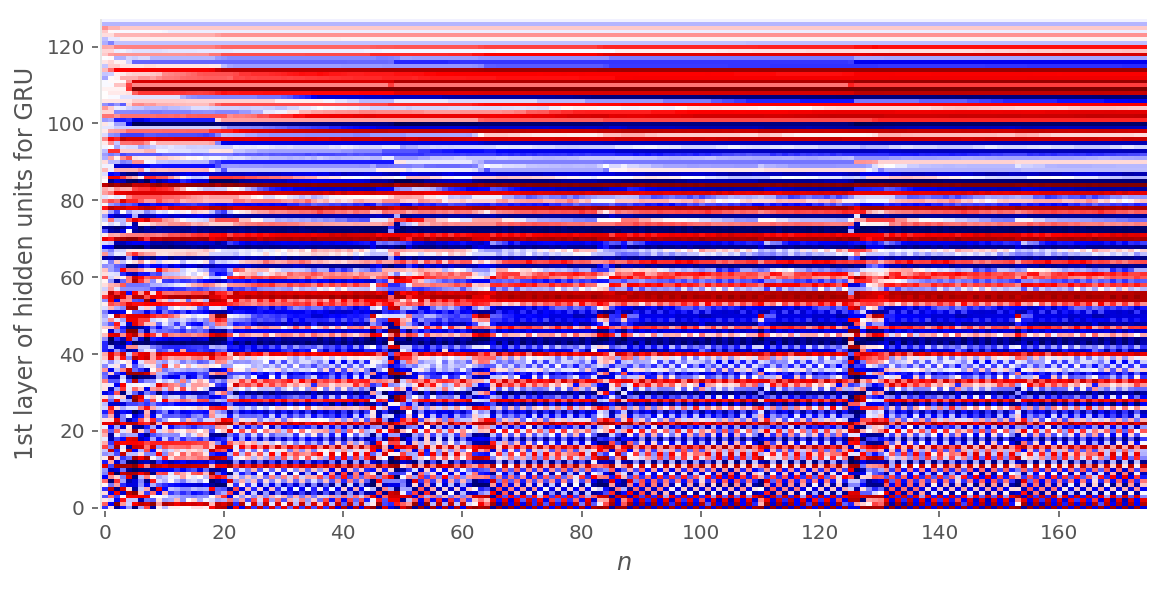

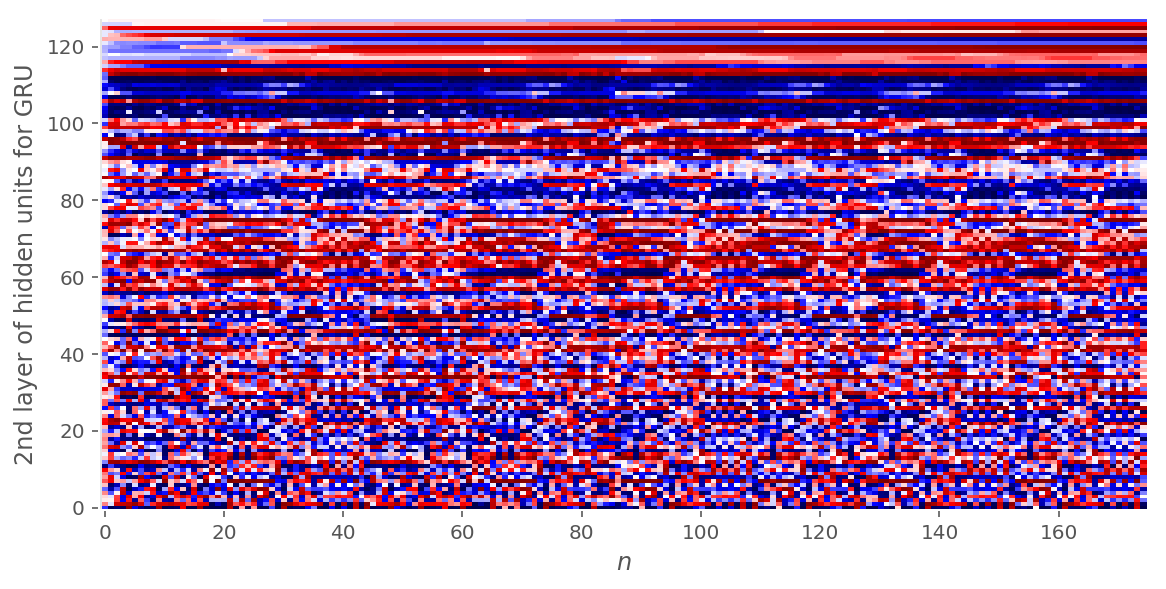

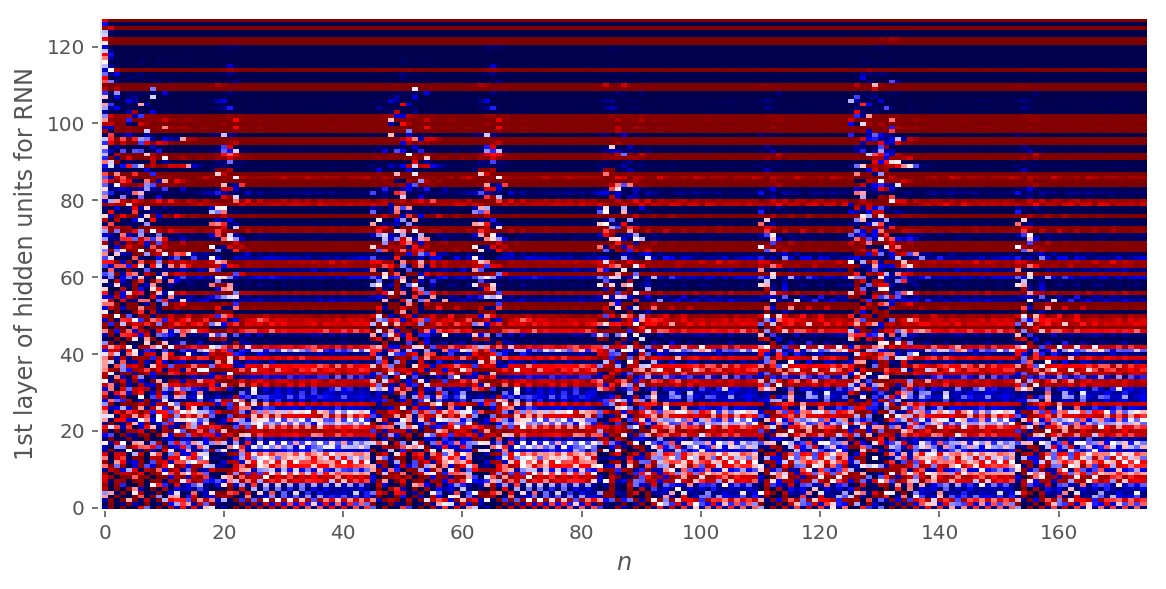

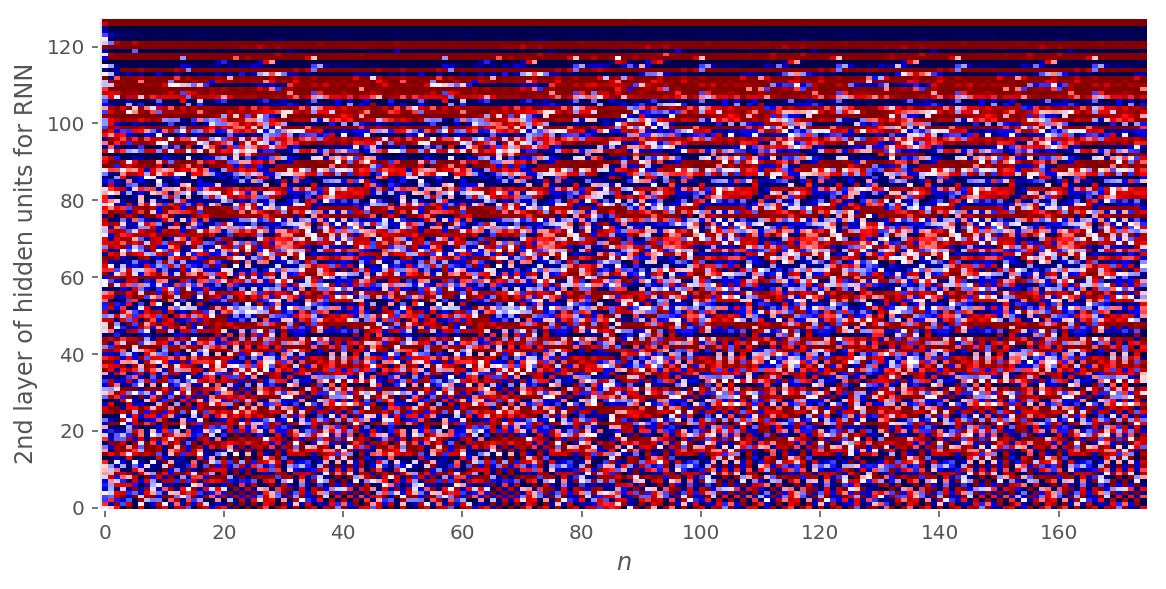

Melody at index 1767
Accuracy for pitch: 0.024875621890547265 , Accuracy for duration: 0.22388059701492538


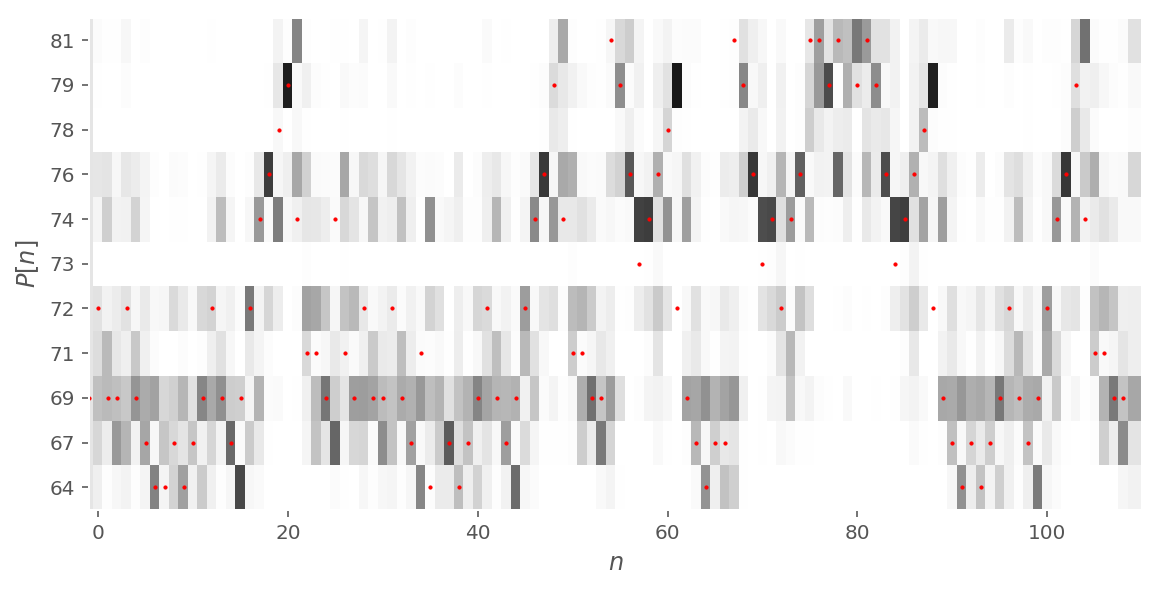

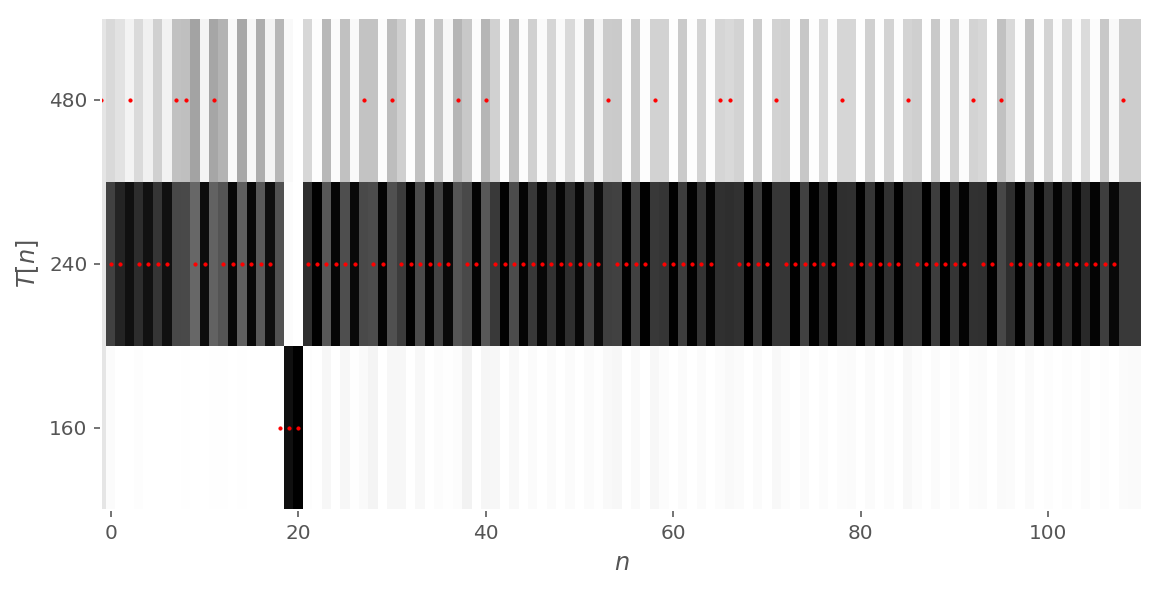

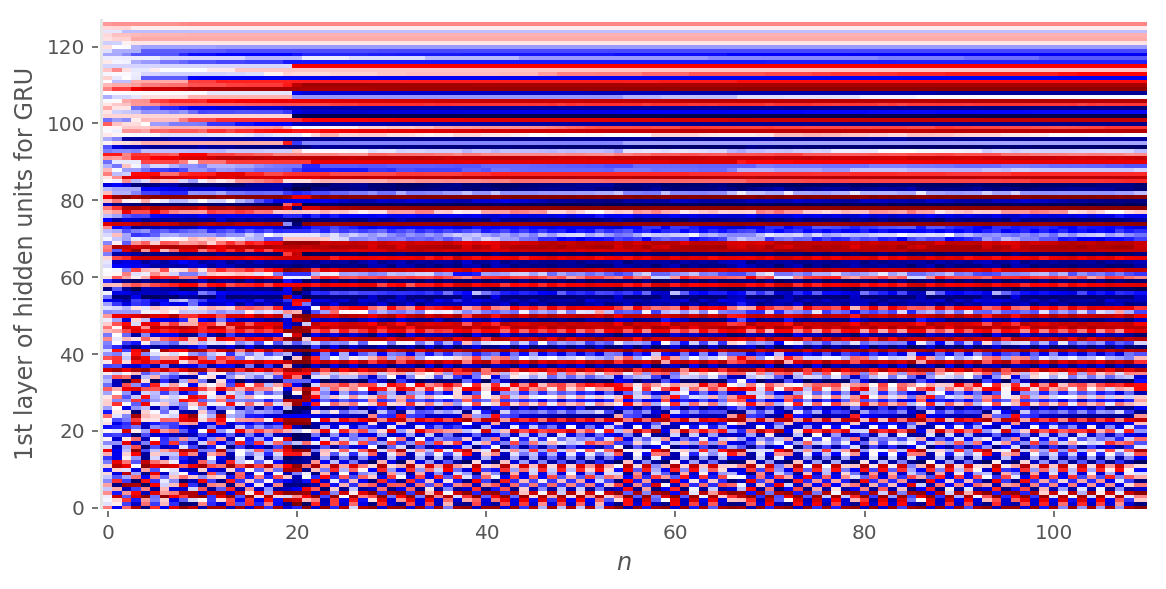

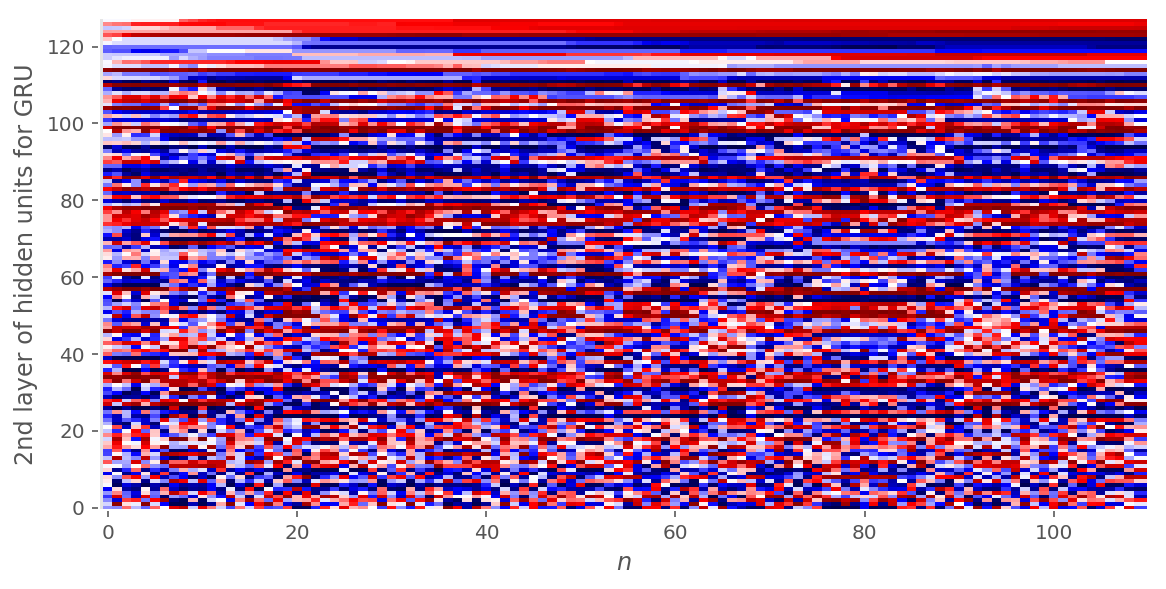

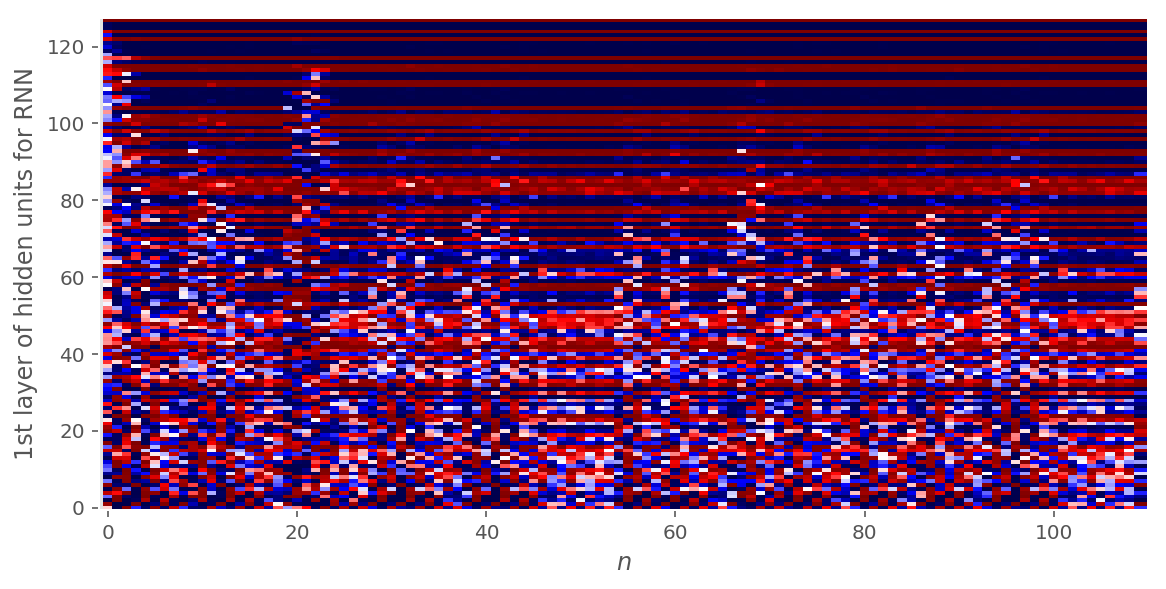

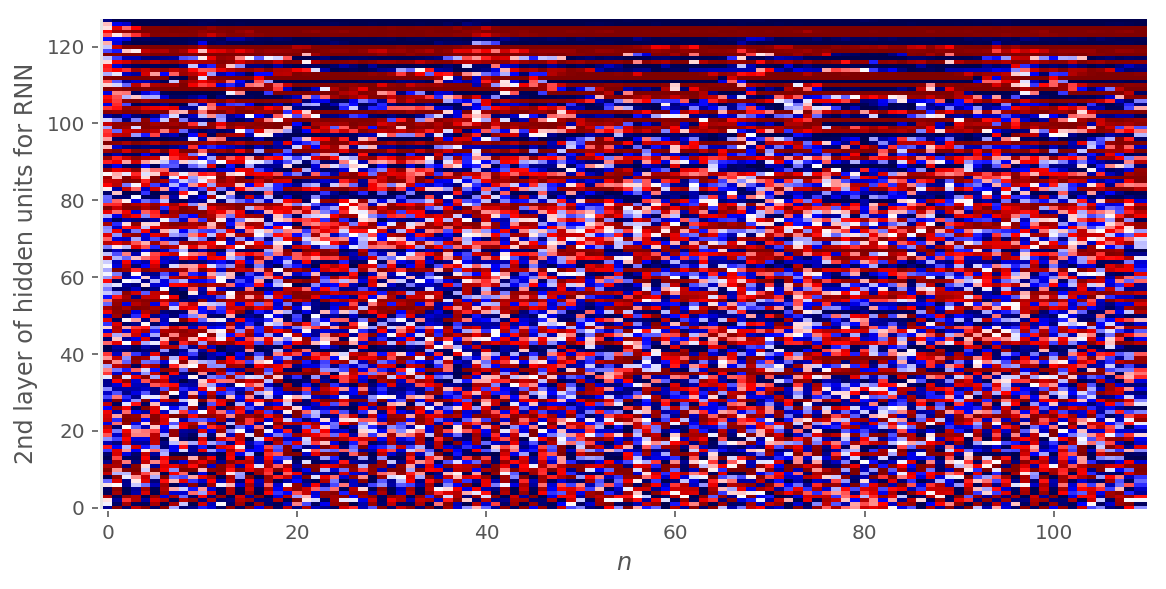

In [28]:
random = np.random.choice(range(len(pitches)), 4)


for index in random:
    print("Melody at index {}".format(index))

    # Convert the data to the correct type to feed the neural net
    P = np.array([pitches[index].tolist()[:-1]])
    T = np.array([durations[index].tolist()[:-1]])
    
    # Get the predictions of the best model
    prediction = model_GRU.predict({"XP": P, "XT": T})
    predicted_T = prediction[0][0]
    predicted_P = prediction[1][0]
    
    # Print the accuracy of the predictions
    print_acc(predicted_T, predicted_P)
    
    # Get the hidden states of GRU
    hidden_states = modified_GRU.predict({"XP": P, "XT": T})
    H1 = hidden_states[0][0]
    H2 = hidden_states[1][0]
    
    # Get the hidden states of RNN
    hidden_states = modified_RNN.predict({"XP": P, "XT": T})
    H3 = hidden_states[0][0]
    H4 = hidden_states[1][0]
    
    # Plot everything
    plotMelody(pitches[index], durations[index], inverse_dict, PrP=predicted_P, PrT=predicted_T, H1=H1, H2=H2, H3=H3, H4=H4)

question 3:

In [16]:
def get_activation_changes(modified_model):
    changes1 = np.zeros(128)
    changes2 = np.zeros(128)
    total = 0
    for pitch, duration in zip(pitches, durations):
        
        P = np.array([pitch.tolist()[:-1]])
        T = np.array([duration.tolist()[:-1]])

        hidden_states = modified_model.predict({"XP": P, "XT": T})
        H1 = hidden_states[0][0]
        H2 = hidden_states[1][0]
        
        last_epoch = H1[0]
        for epoch in H1[1:]:
            changes1 = [abs(previous - value) + changes1[index] for index, (previous, value) in enumerate(zip(last_epoch, epoch))]
            last_epoch = epoch
            
        last_epoch = H2[0]
        for epoch in H2[1:]:
            changes2 = [abs(previous - value) + changes2[index] for index, (previous, value) in enumerate(zip(last_epoch, epoch))]
            last_epoch = epoch
            
        total = total + len(H1[1:])
    
    changes = changes1 + changes2
    changes = [change/total for change in changes]
    return changes

In [17]:
# Compute the average absolute change in activation in both model
rnn_changes = get_activation_changes(modified_RNN)
gru_changes = get_activation_changes(modified_GRU)

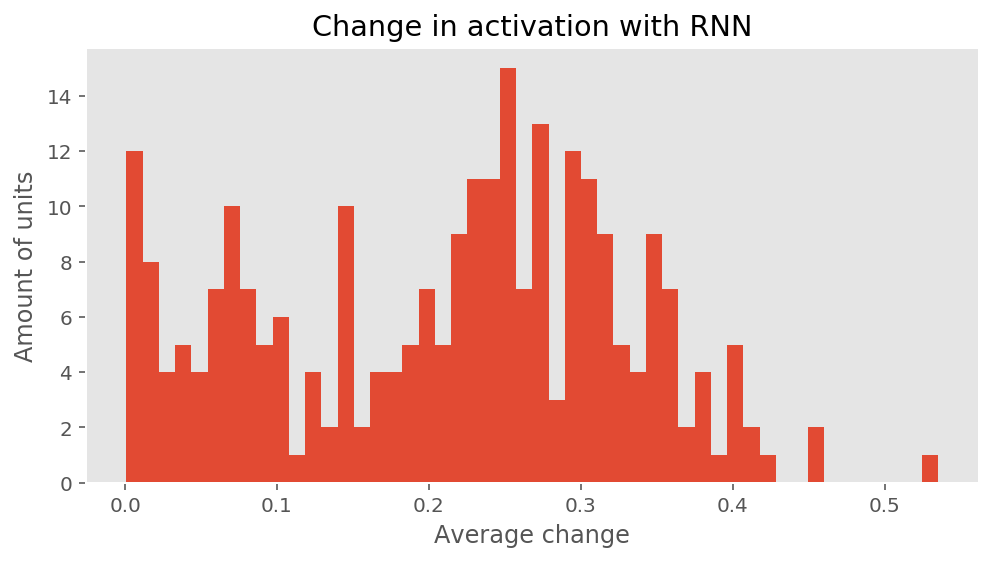

In [20]:
plt.hist(x=rnn_changes, bins=50)
plt.title('Change in activation with RNN')
plt.xlabel('Average change')
plt.ylabel('Amount of units')
plt.show()

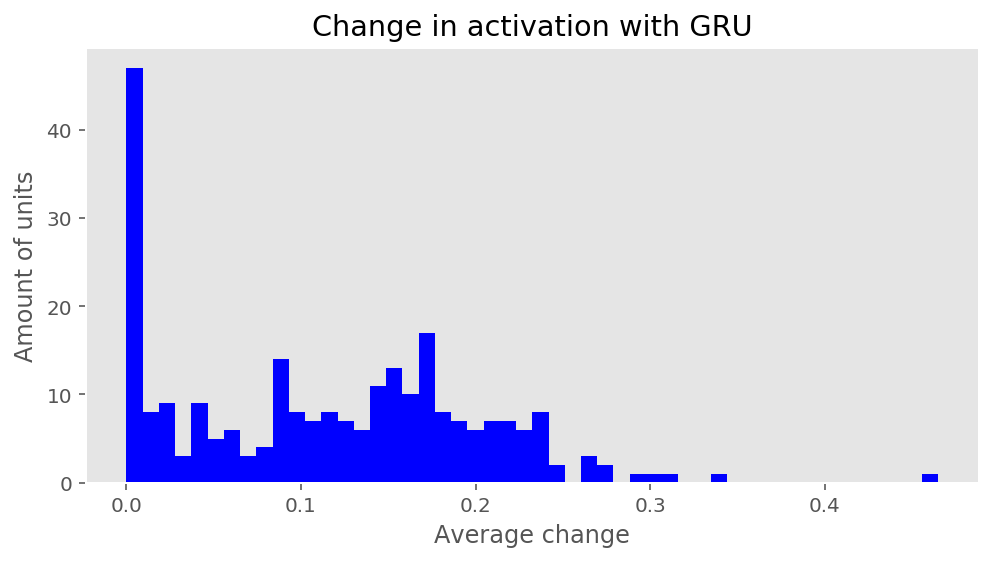

In [29]:
plt.hist(x=gru_changes, bins=50, color = "blue")
plt.title('Change in activation with GRU')
plt.xlabel('Average change')
plt.ylabel('Amount of units')
plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: From both 6.2, we can see more vertical lines in the GRU hidden states, which means that the variation in the hidden states were less important than with RNN. We get the same insight from 6.3: most hidden units change their activation values by 0.3 in average for RNN against close to 0 for GRU. This shows that GRU performs better in finding rapidly a steady state for the hidden states activation values than RNN that keep searching for the right hidden states activation values which explains the performance differences stated above.


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [32]:
import random
def generate_melody(model, temp, melody_length):
    """Function that generates a melody by feeding the neural model starting with a random note.
    It returns an array of duration and pitches"""
    # Generate the first note randomly
    random_pitch = np.zeros(len(inverse_dict["P"]))
    random_duration = np.zeros(len(inverse_dict["T"]))
    random_pitch[random.randint(0,len(inverse_dict["P"]) - 1)] = 1
    random_duration[random.randint(0,len(inverse_dict["T"]) - 1)] = 1
    
    t = sample(random_duration, temperature = temp)
    p = sample(random_pitch, temperature = temp)
    
    durations = [t]
    pitches = [p]
    
    # The neural networks only accept ndarrays of shape 403 * 17 for durations, * 53 for durations,
    pitches_for_network = np.zeros((max_length - 1, len(inverse_dict["P"])))
    durations_for_network = np.zeros((max_length - 1, len(inverse_dict["T"])))
    actual_note = [random_pitch, random_duration]
    n = 0
    # Feed the network starting with the random note until we have 100 notes
    while n < melody_length: 
        pitches_for_network[n] = actual_note[0]
        durations_for_network[n] = actual_note[1]
        
        prediction = model.predict({"XP": np.array([pitches_for_network.tolist()]), "XT": np.array([durations_for_network.tolist()])})
        # Get the next note in prediction (at index n + 1)
        predicted_T = prediction[0][0][n + 1]
        predicted_P = prediction[1][0][n + 1]
        
        durations.append(sample(predicted_T, temperature = temp))
        pitches.append(sample(predicted_P, temperature = temp))
        
        # We need to convert the array of predictions as does the softmax method (max of each row set to 1 and rest to 0)
        predicted_T[np.argmax(predicted_T)] = 1
        predicted_P[np.argmax(predicted_P)] = 1
        predicted_T[predicted_T < max(predicted_T)] = 0
        predicted_P[predicted_P < max(predicted_P)] = 0
        
        actual_note = [predicted_P, predicted_T]
        n += 1
    return durations, pitches

With temperature = 1.0:

In [23]:
# With RNN
durs, pitchs = generate_melody(model_RNN, temp = 1.0, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/RNN_10.mid")

# With GRU
durs, pitchs = generate_melody(model_GRU, temp = 1.0, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/GRU_10.mid")

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: RuntimeWarning: divide by zero encountered in log


With temperature = 0.5:

In [24]:
# With RNN
durs, pitchs = generate_melody(model_RNN, temp = 0.5, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/RNN_05.mid")

# With GRU
durs, pitchs = generate_melody(model_GRU, temp = 0.5, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/RNN_05.mid")

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: RuntimeWarning: divide by zero encountered in log


With temperature = 1.5:

In [25]:
# With RNN
durs, pitchs = generate_melody(model_RNN, temp = 1.5, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/RNN_15.mid")

# With GRU
durs, pitchs = generate_melody(model_GRU, temp = 1.5, melody_length = 100)
writeMIDI(pitchs, durs, inverse_dict, "generated_chorpus/testing/RNN_15.mid")

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: RuntimeWarning: divide by zero encountered in log


Generate the 32 melodies, 16 with RNN and 16 with the GRU model:

In [33]:
for i in range(1, 33):
    if i % 2 == 0:
        # With RNN
        durs, pitchs = generate_melody(model_RNN, temp = 1.0, melody_length = 100)
        filename = "generated_chorpus/RNN_" + str(int(i / 2)) + ".mid"
        writeMIDI(pitchs, durs, inverse_dict, filename)
    else:
        # With GRU
        durs, pitchs = generate_melody(model_GRU, temp = 1.0, melody_length = 100)
        filename = "generated_chorpus/GRU_" + str(int(i / 2) + 1) + ".mid"
        writeMIDI(pitchs, durs, inverse_dict, filename)

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: RuntimeWarning: divide by zero encountered in log


Display the stream of the generated MIDI files:

In [34]:
random_nbrs = np.random.choice(range(1,17), 2)
for i in random_nbrs:
    filename_RNN = "generated_chorpus/RNN_" + str(i) + ".mid"
    filename_GRU = "generated_chorpus/GRU_" + str(i) + ".mid"
    print(filename_RNN)
    music21.midi.translate.midiFilePathToStream(filename_RNN).show('midi')
    print(filename_GRU)
    music21.midi.translate.midiFilePathToStream(filename_GRU).show('midi')

generated_chorpus/RNN_8.mid


generated_chorpus/GRU_8.mid


generated_chorpus/RNN_2.mid


generated_chorpus/GRU_2.mid


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: From hearing the different generated melodies, it seems that the higher the sampling temperature, the more variations in pitches and duration in the melody. For instance, with temperature 0.5, it seems that one particular note (pitch) occur a lot and the durations of all notes are moreless the same. However, with a 1.5 temperature, the pitches tend to vary between the lows and highs and the durations between notes vary more.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: The melodies generated by the GRU model are more "pleasant" to hear than the ones generated by RNN. In fact we have seen from the accuracy plots that the GRU model is more accurate than the RNN model. When hearing the GRU melodies, there are barely no fake notes (unpleasant for the hear) whereas there are some in the melodies generated by RNN. When there is an odd note, the RNN model tend to behave oddly whereas the GRU model has more "stability", this is coherent with the remarks on the hidden states made in part 6.

